In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from time import time
from imutils import contours
from skimage import measure
import imutils
import cv2

paths = glob('../data/test/*')

In [43]:
def timer(f):
    def wrapper(*a, **b):
        start = time()
        rv = f(*a, **b)
        end = time()
        print('Run time {}:  {:0.2f}'.format(f.__name__, end-start))
        return rv
    return wrapper

@timer
def read_image(path, channel=None, resize=None):
    img = cv2.imread(path)
    if resize is not None:
        img = cv2.resize(img, (0, 0), fx=resize, fy=resize)
    if channel is not None:
        return img[:,-img.shape[1]//2:, channel]
    
    return img

@timer
def show(image, cmap=None, figsize=20):
    plt.figure(figsize=(figsize, figsize))
    if cmap is not None:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    plt.show()
    
def process(image, mode, kernel_size=20, thresh=None):
    if mode == 'get_h_line':
        kernel = np.ones([1, kernel_size])
        image = cv2.erode(image, kernel=kernel)
        image = cv2.dilate(image, kernel=kernel)
    if mode == 'get_v_line':
        kernel = np.ones([kernel_size, 1])
        image = cv2.erode(image, kernel=kernel)
        image = cv2.dilate(image, kernel=kernel)
    if thresh is not None:
        image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]
    return image

def find_connected_component(image):
    return cv2.connectedComponents(image, 8)

In [44]:
def find_straight_line(img, cnt):
    mask = np.zeros_like(img)
    rows,cols = img.shape[:2]
    [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    cv2.line(mask,(cols-1,righty),(0,lefty),(255),2)
    return mask, (cols-1,righty),(0,lefty)

In [45]:
def find_minArea(img, cnt):
    mask = np.zeros_like(img)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    mask = cv2.drawContours(mask,[box],0,(255,0,0), -1)
    return mask

In [46]:
def distance(p1, p2):
    return np.sqrt(np.square(np.array(p1)-np.array(p2))).sum()

In [47]:
def put_text(img, cnt, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    M = cv2.moments(cnt)
    cx = int(cnt[:,0].mean())
    cy = int(cnt[:,1].mean())
    cv2.putText(img, text, (cx, cy), font, 1,(255,0,0),2,cv2.LINE_AA)
    return img

In [48]:

def get_contour(thresh):
    cnts = []
    labels = measure.label(thresh, neighbors=8, background=0)
    for label in np.unique(labels):
        if label == 0:
            continue
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        if numPixels > 400:
            cnt = np.column_stack(np.where(labels == label))
            cnt = np.flip(cnt, 1)
            cnts.append(cnt)
    return cnts

In [103]:
def is_same_line(cnt1, cnt2):
    bbox1 = cv2.boundingRect(cnt1)
    bbox2 = cv2.boundingRect(cnt2)
    if bbox1[0] >bbox2[0]:
        _ = bbox1
        bbox1 = bbox2
        bbox2 = _
    if bbox1[0] +bbox1[3] < bbox2[0]:
        return True
    return False
            
@timer
def connect_line(line_image, resize=1, intersec_rate=.6):
    cnts = get_contour(line_image)
    line = np.zeros_like(line_image)
    for i in range(len(cnts)):
        c1 = cnts[i]
        mask_1 = np.count_nonzero(find_minArea(line, c1))
        for j in range(i+1, len(cnts), 1):
            c2 = cnts[j]
            c = np.concatenate([c1, c2], axis=0)
            mask_c = np.count_nonzero(find_minArea(line, c))
            mask_2 = np.count_nonzero(find_minArea(line, c2))
            p = (mask_1+mask_2)/mask_c
            if p > intersec_rate and is_same_line(c1, c2):
                x1, y1 = np.mean(c1, axis=0).astype('int32')
                x2, y2 = np.mean(c2, axis=0).astype('int32')
                cv2.line(line, (x1,y1), (x2, y2), 255,int(5*resize))
    rv = cv2.add(line, line_image)
    return rv

../data/test/SG1-28.png
Run time read_image:  0.07
Run time connect_line:  0.14
Run time connect_line:  0.10


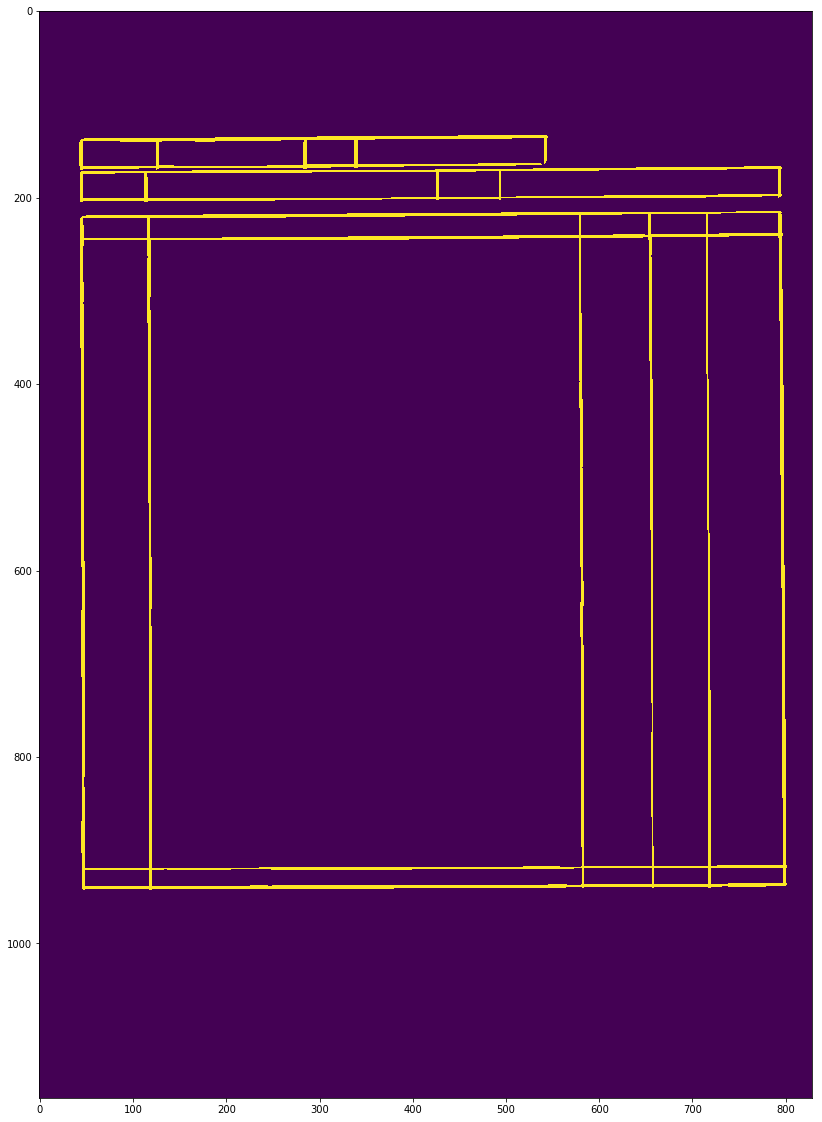

Run time show:  0.46
../data/test/SG1-47.png
Run time read_image:  0.07
Run time connect_line:  0.09
Run time connect_line:  0.04


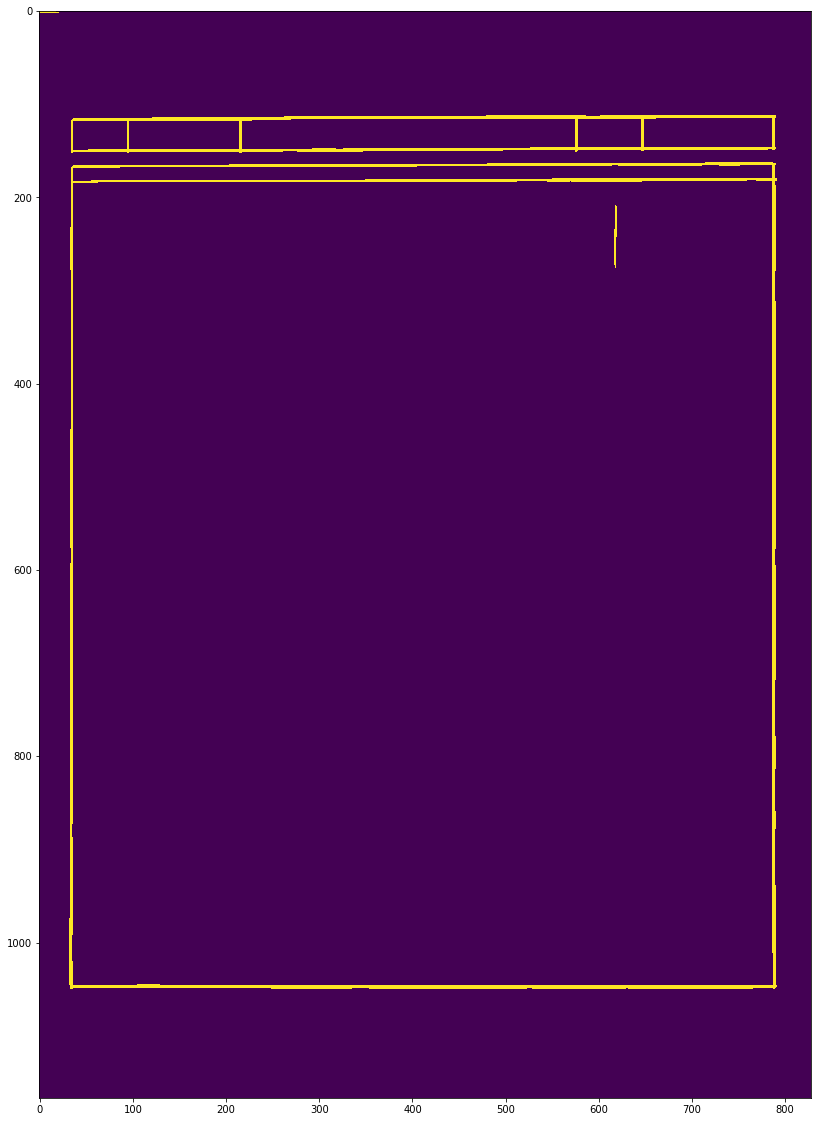

Run time show:  0.46
../data/test/SG1-44.png
Run time read_image:  0.17
Run time connect_line:  0.64
Run time connect_line:  0.65


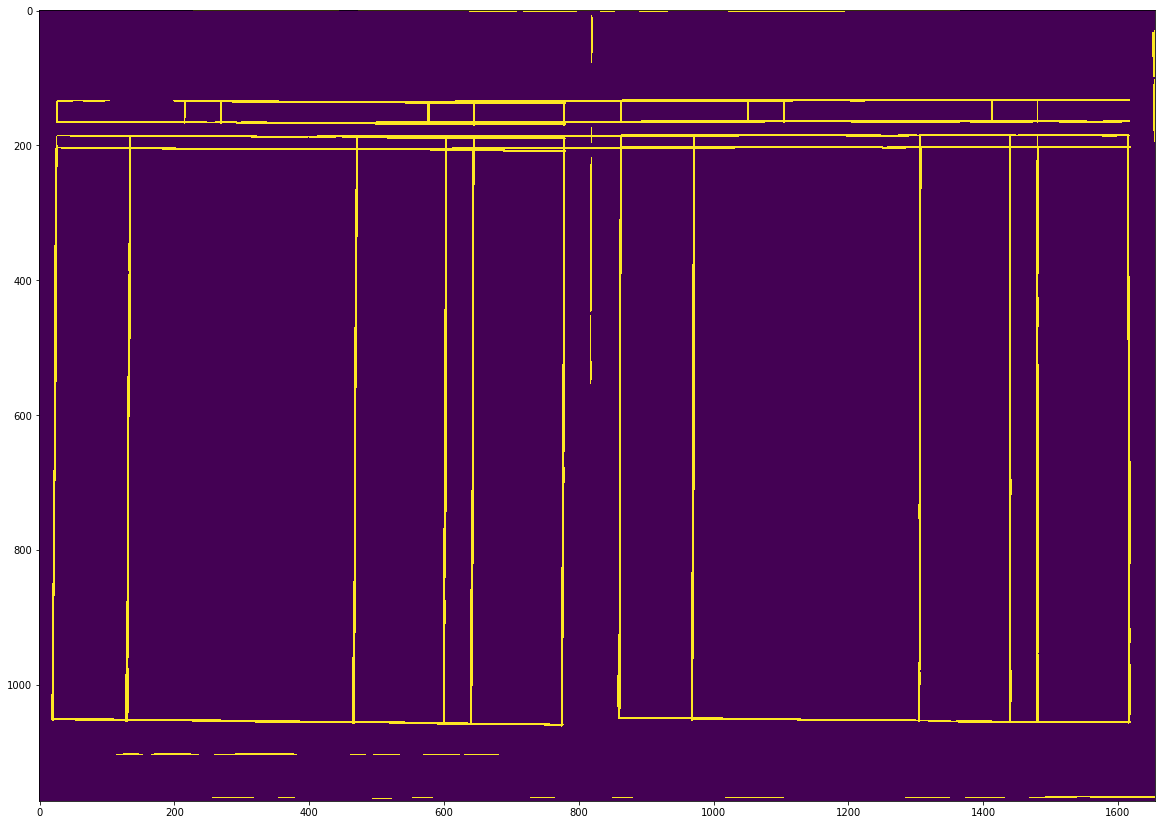

Run time show:  0.48
../data/test/SG1-32.png
Run time read_image:  0.10
Run time connect_line:  0.04
Run time connect_line:  0.09


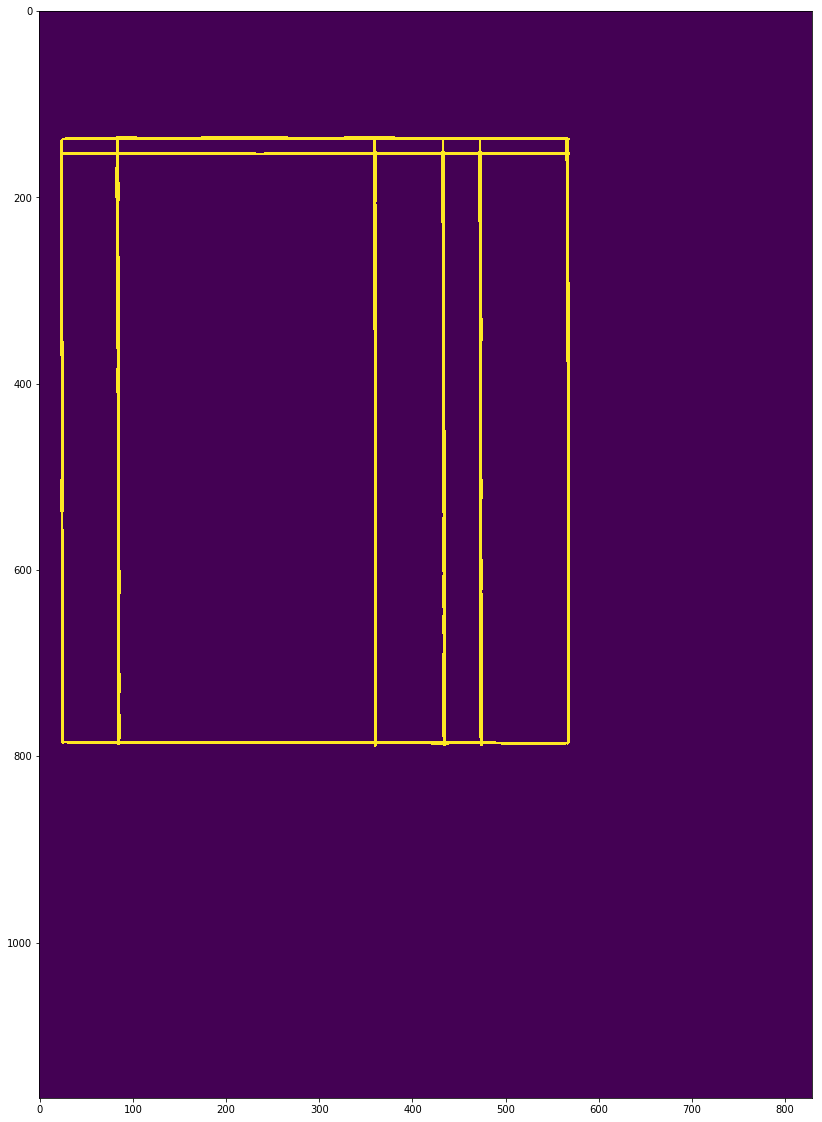

Run time show:  0.46
../data/test/SG1-22.png
Run time read_image:  0.08
Run time connect_line:  0.08
Run time connect_line:  0.11


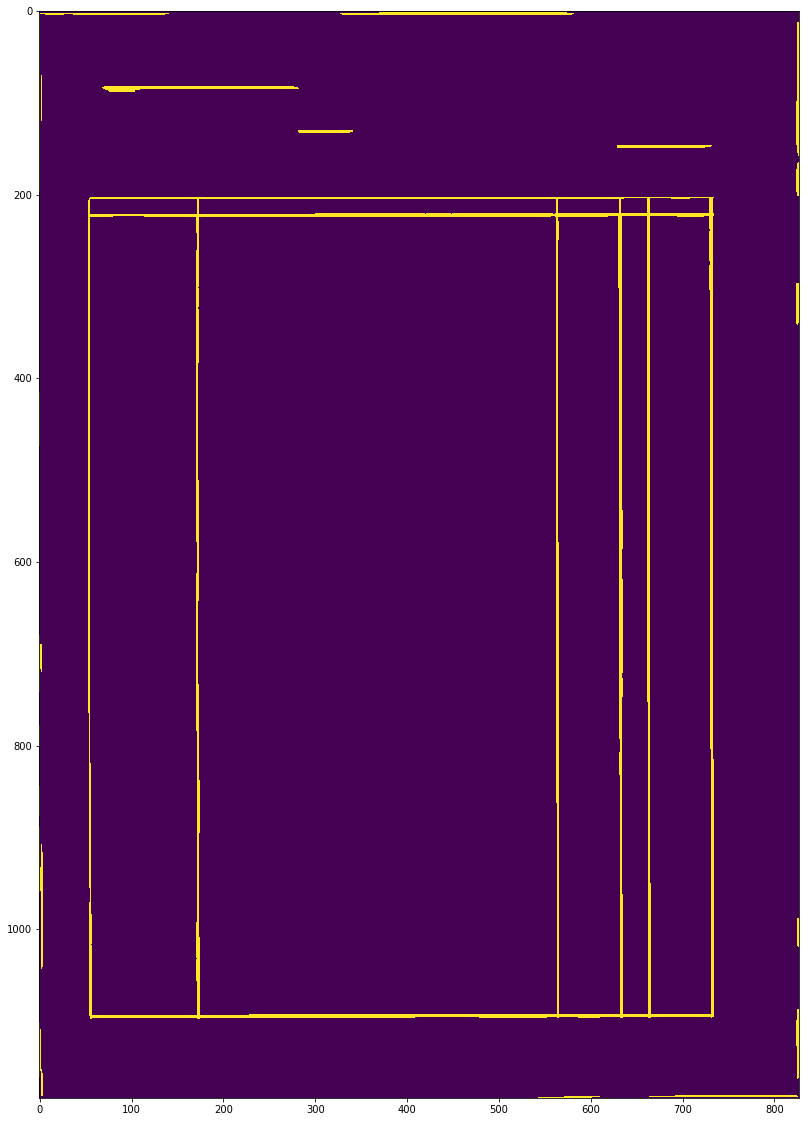

Run time show:  0.45
../data/test/SG1-42.png
Run time read_image:  0.08
Run time connect_line:  0.08
Run time connect_line:  0.08


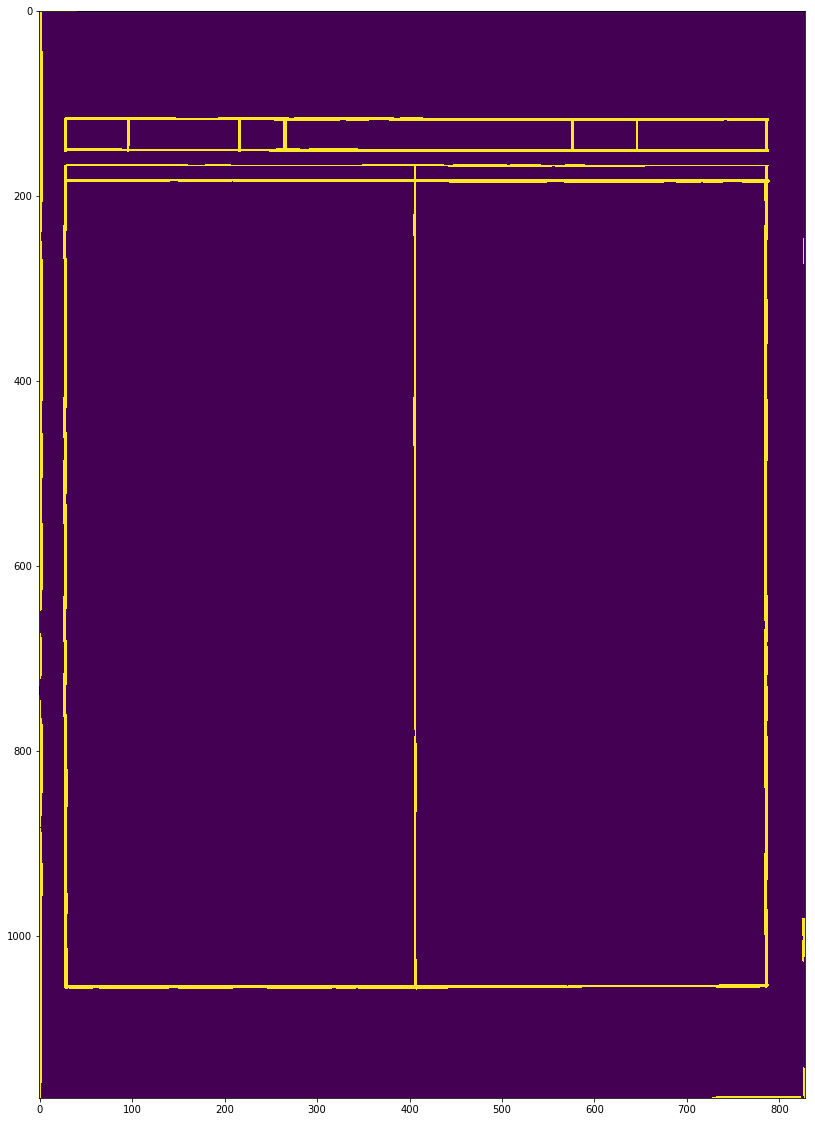

Run time show:  0.45
../data/test/SG1-13.png
Run time read_image:  0.08
Run time connect_line:  0.09
Run time connect_line:  0.06


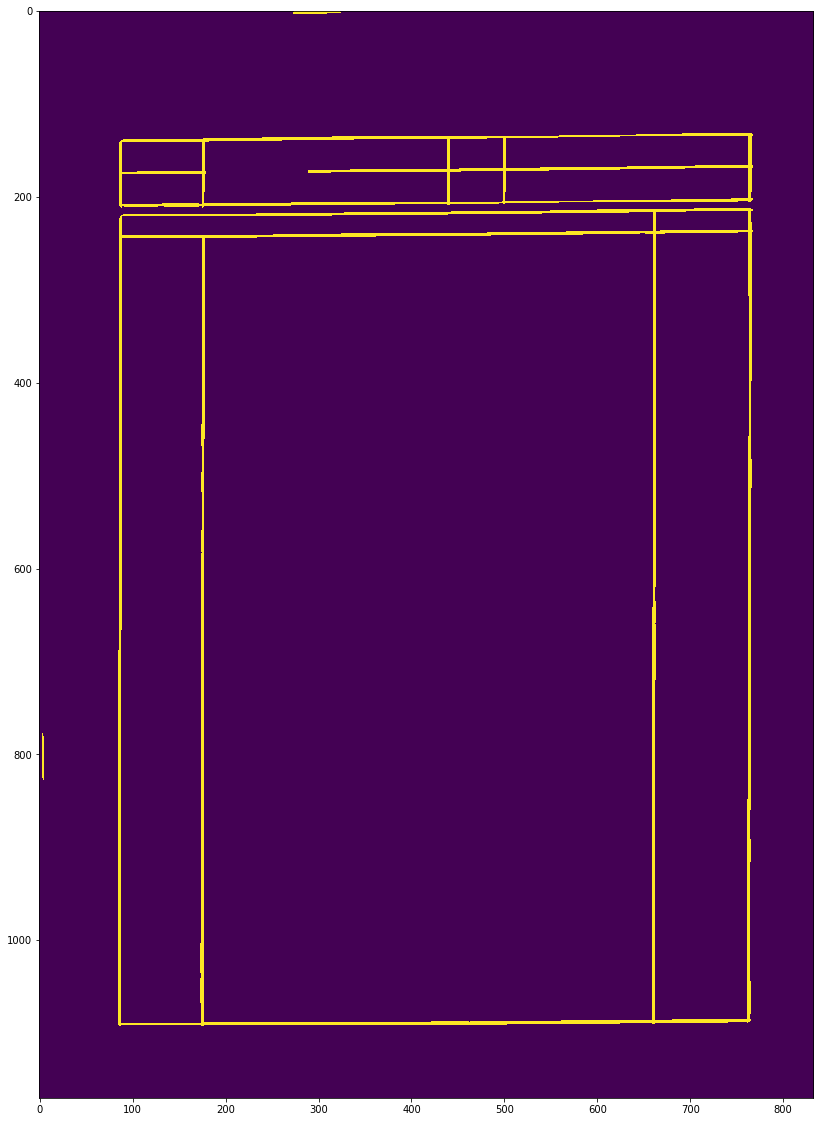

Run time show:  0.42
../data/test/SG1-41-2.png
Run time read_image:  0.06
Run time connect_line:  0.13
Run time connect_line:  0.13


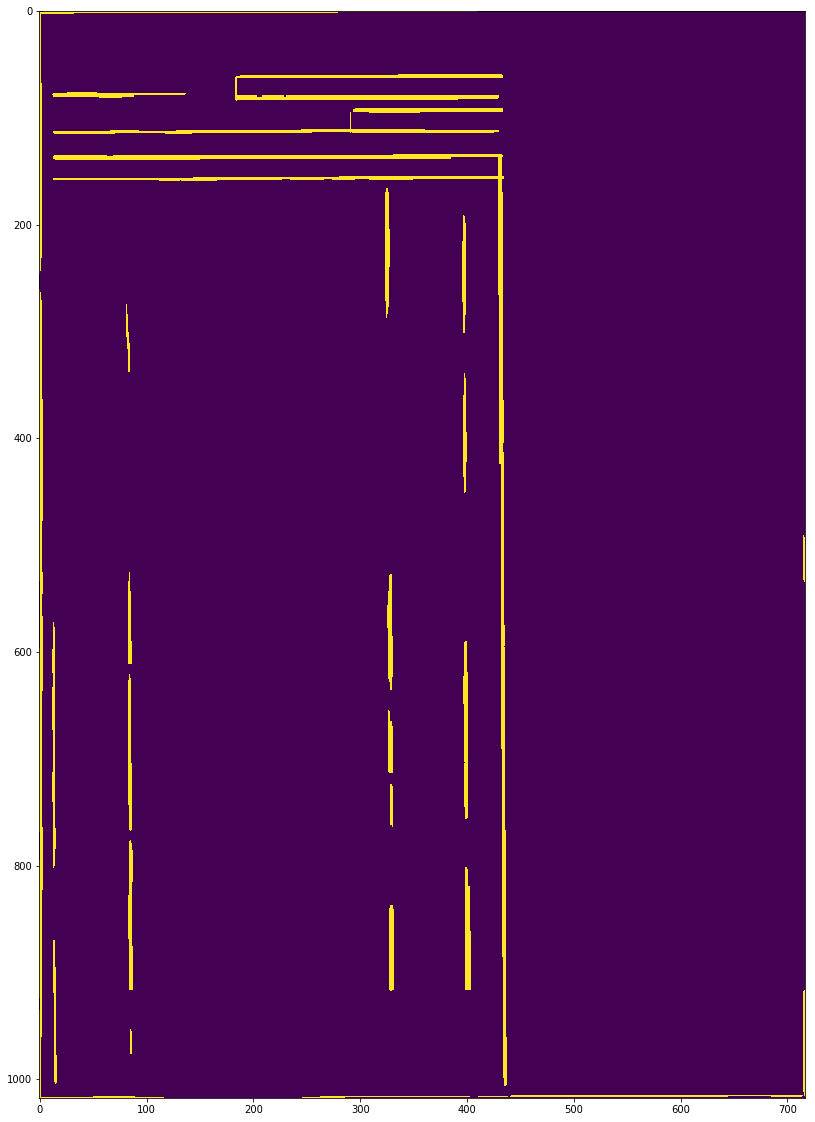

Run time show:  0.45
../data/test/SG1-21.png
Run time read_image:  0.10
Run time connect_line:  0.12
Run time connect_line:  0.10


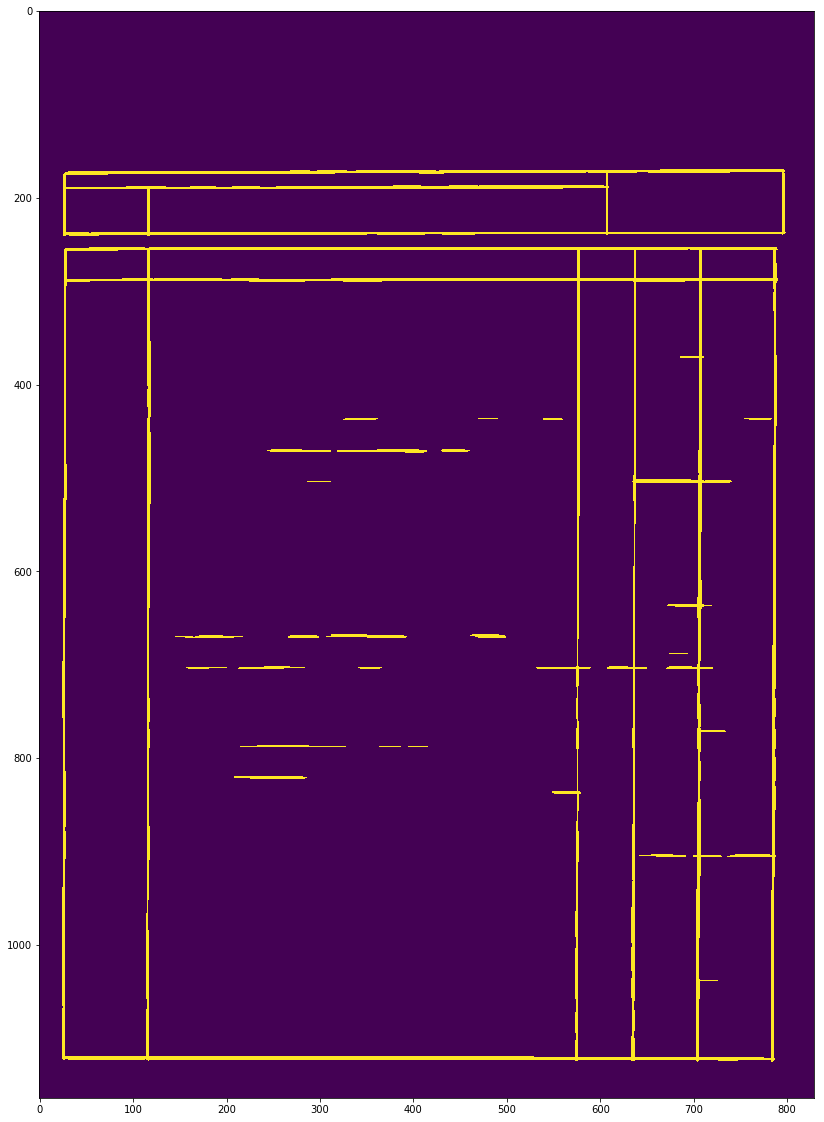

Run time show:  0.46
../data/test/SG1-6.png
Run time read_image:  0.10
Run time connect_line:  0.04
Run time connect_line:  0.07


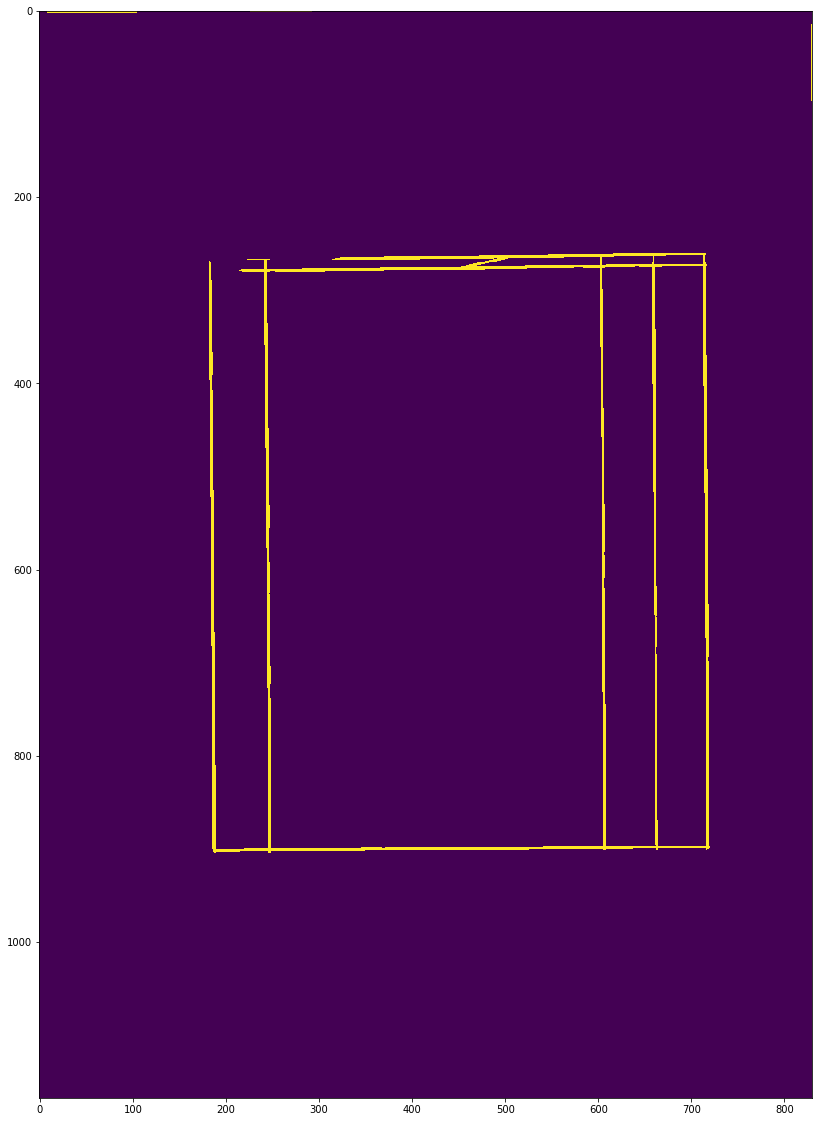

Run time show:  0.46
../data/test/SG1-39.png
Run time read_image:  0.11
Run time connect_line:  0.18
Run time connect_line:  0.11


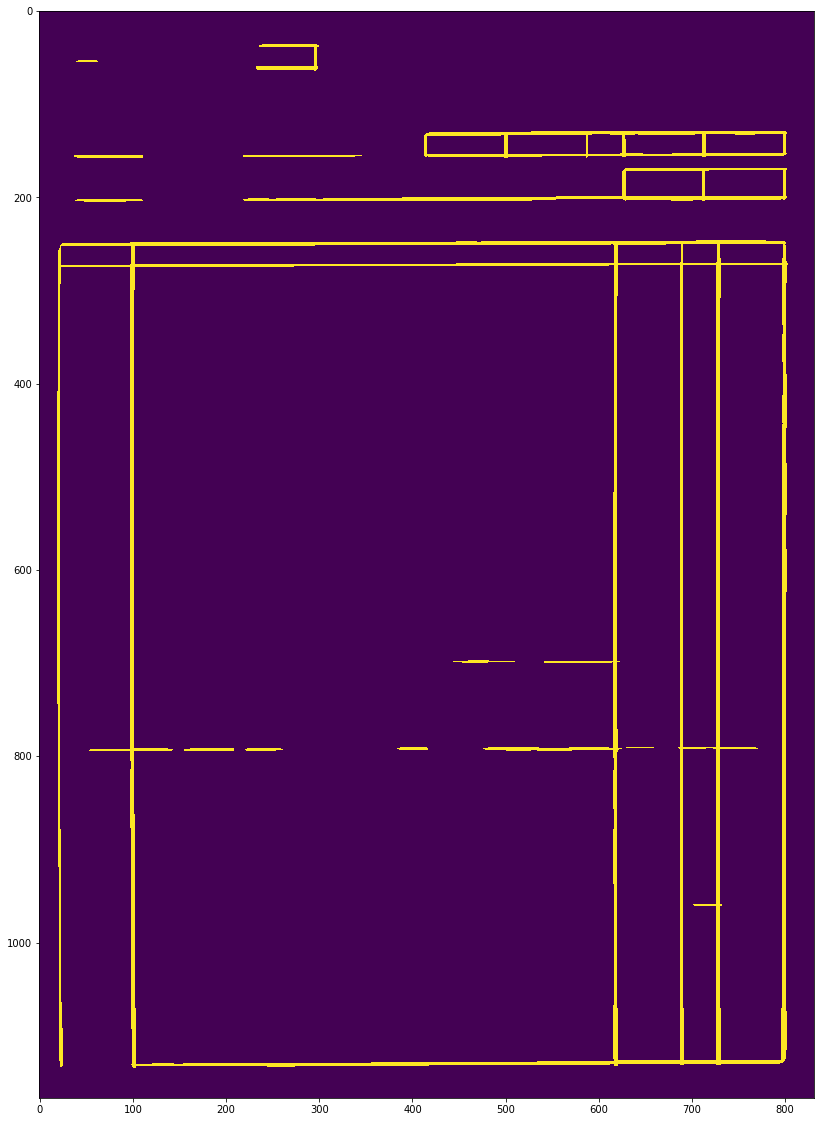

Run time show:  0.49
../data/test/SG1-1-2.png
Run time read_image:  0.10
Run time connect_line:  0.12
Run time connect_line:  0.10


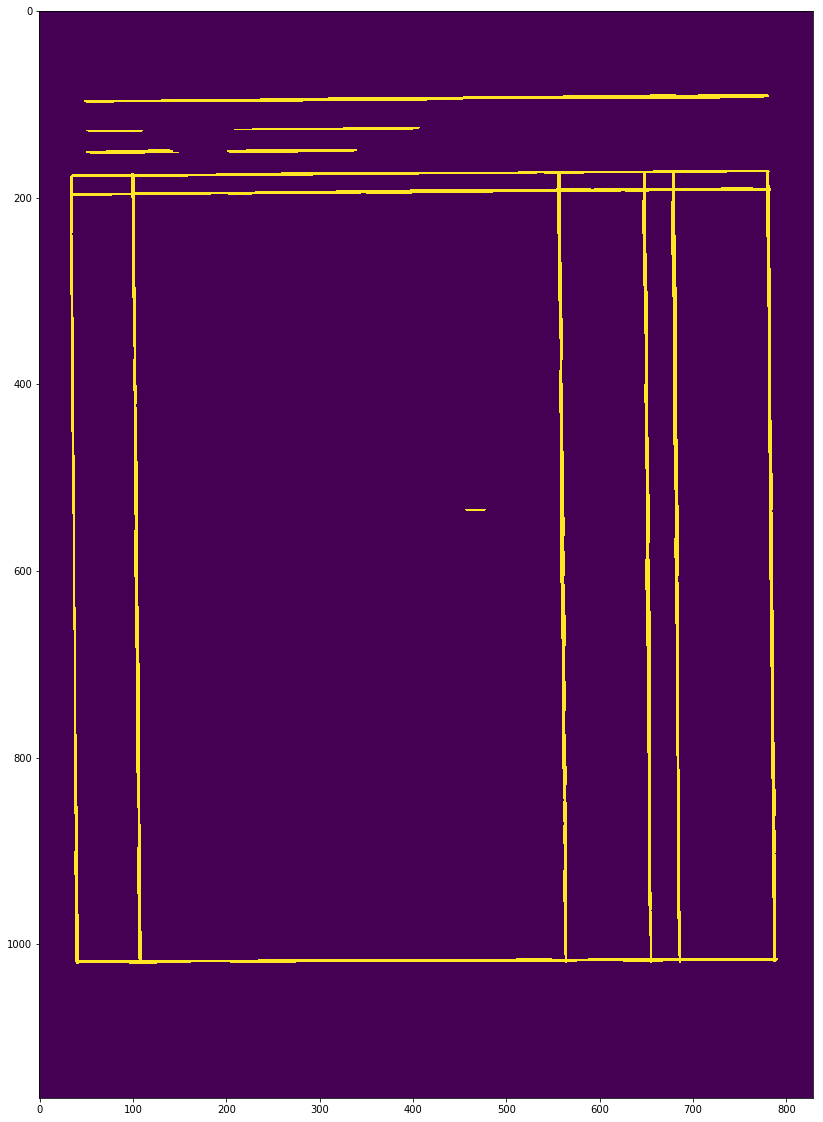

Run time show:  0.42
../data/test/SG1-3-2.png
Run time read_image:  0.06
Run time connect_line:  0.03
Run time connect_line:  0.05


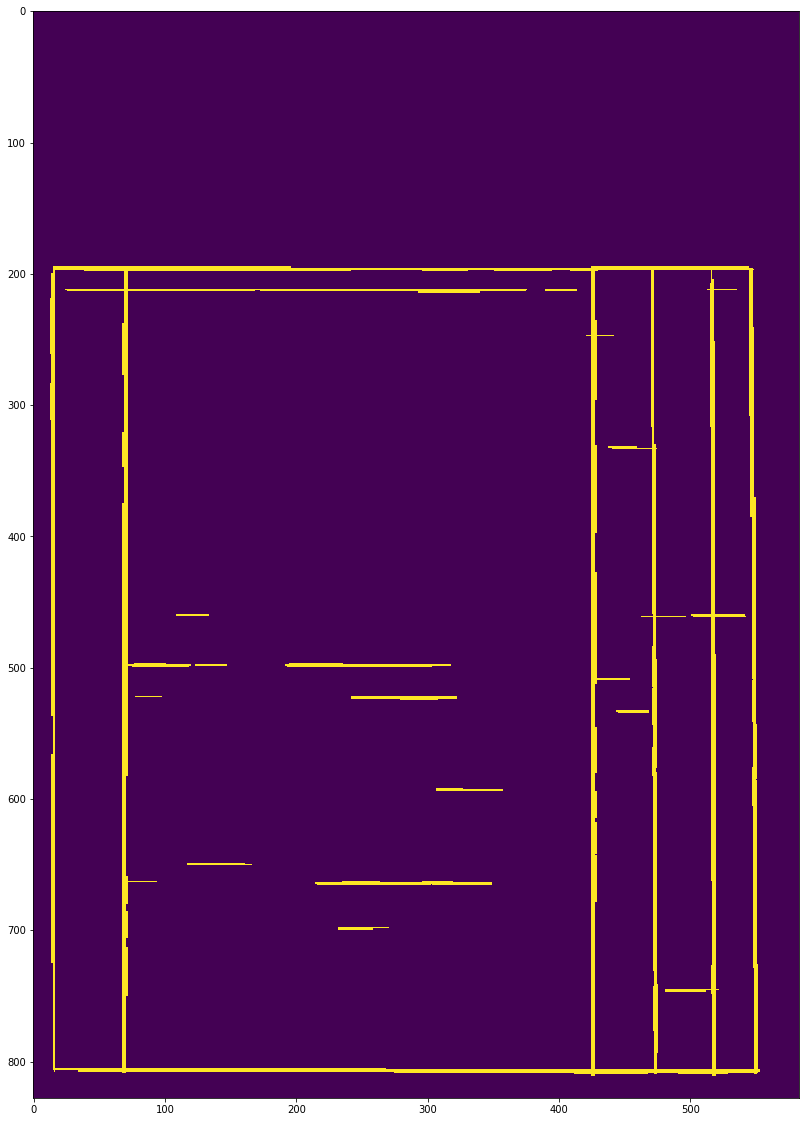

Run time show:  0.45
../data/test/SG1-14.png
Run time read_image:  0.10
Run time connect_line:  0.36
Run time connect_line:  0.13


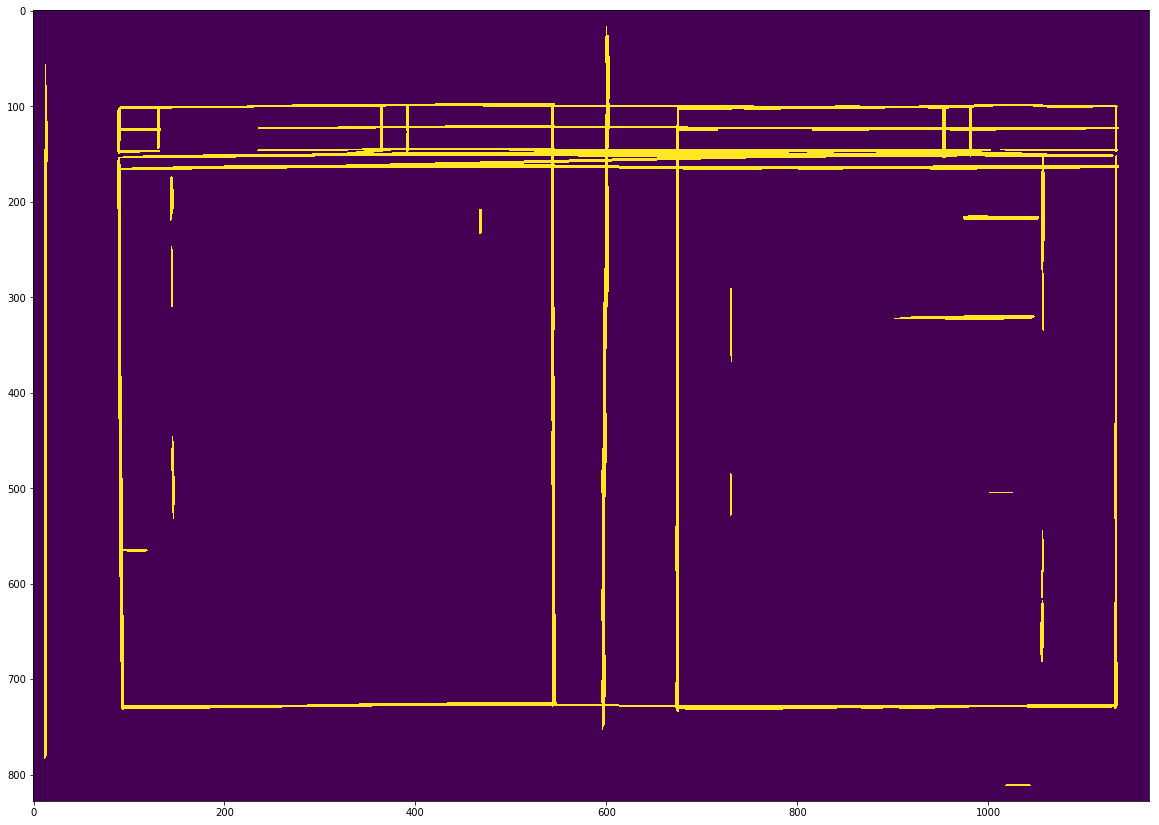

Run time show:  0.46
../data/test/SG1-10-1.png
Run time read_image:  0.09
Run time connect_line:  0.07
Run time connect_line:  0.04


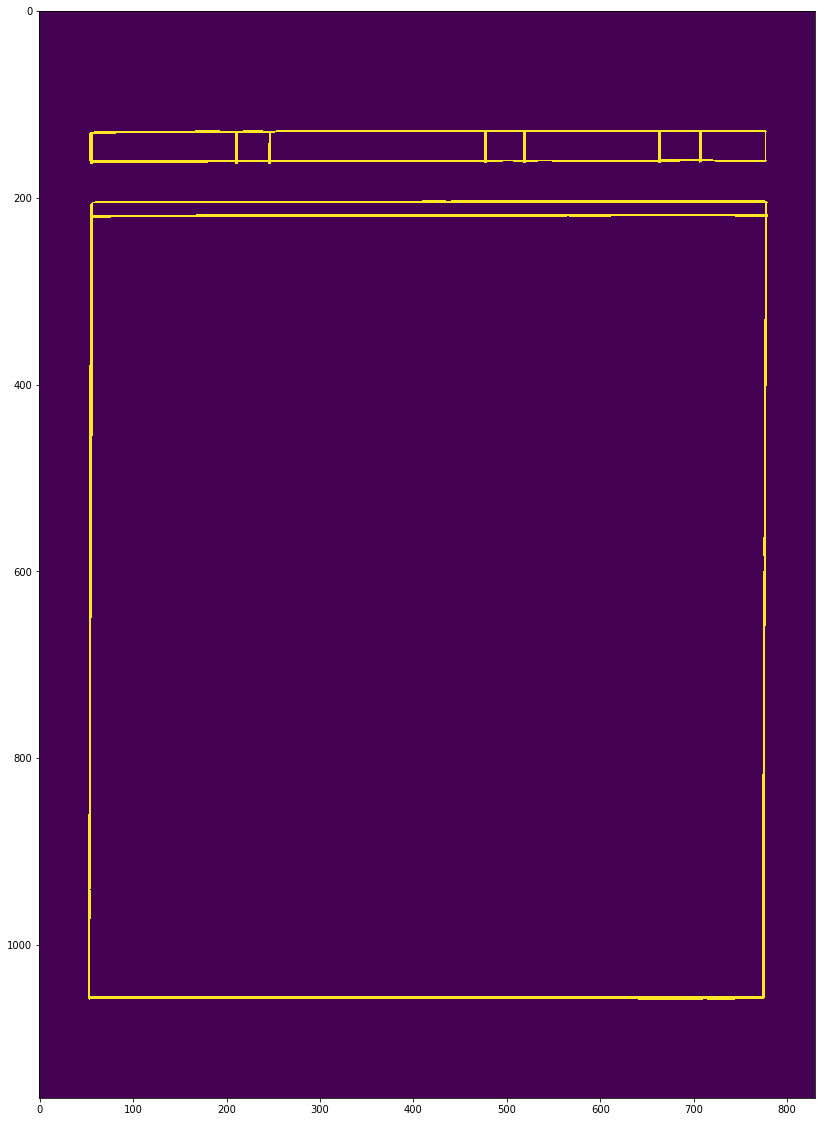

Run time show:  0.46
../data/test/SG1-48-2.png
Run time read_image:  0.10
Run time connect_line:  0.07
Run time connect_line:  0.07


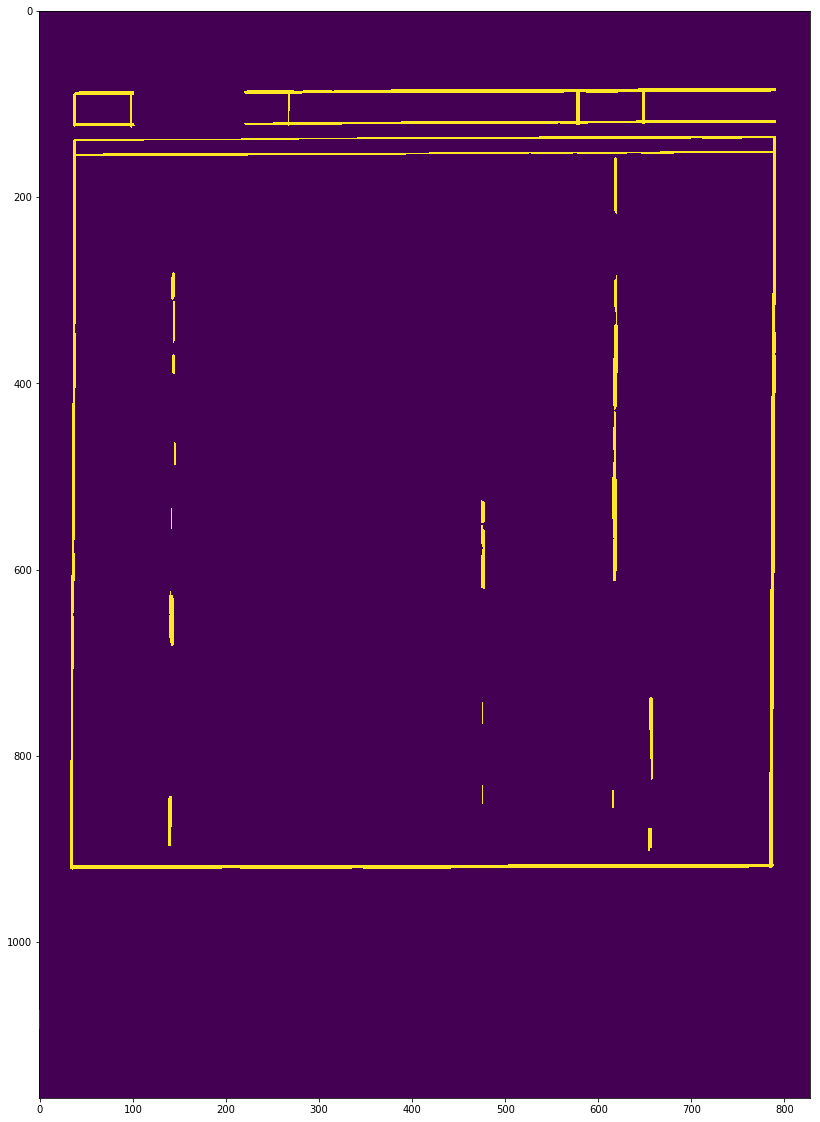

Run time show:  0.46
../data/test/SG1-25.png
Run time read_image:  0.10
Run time connect_line:  0.15
Run time connect_line:  0.10


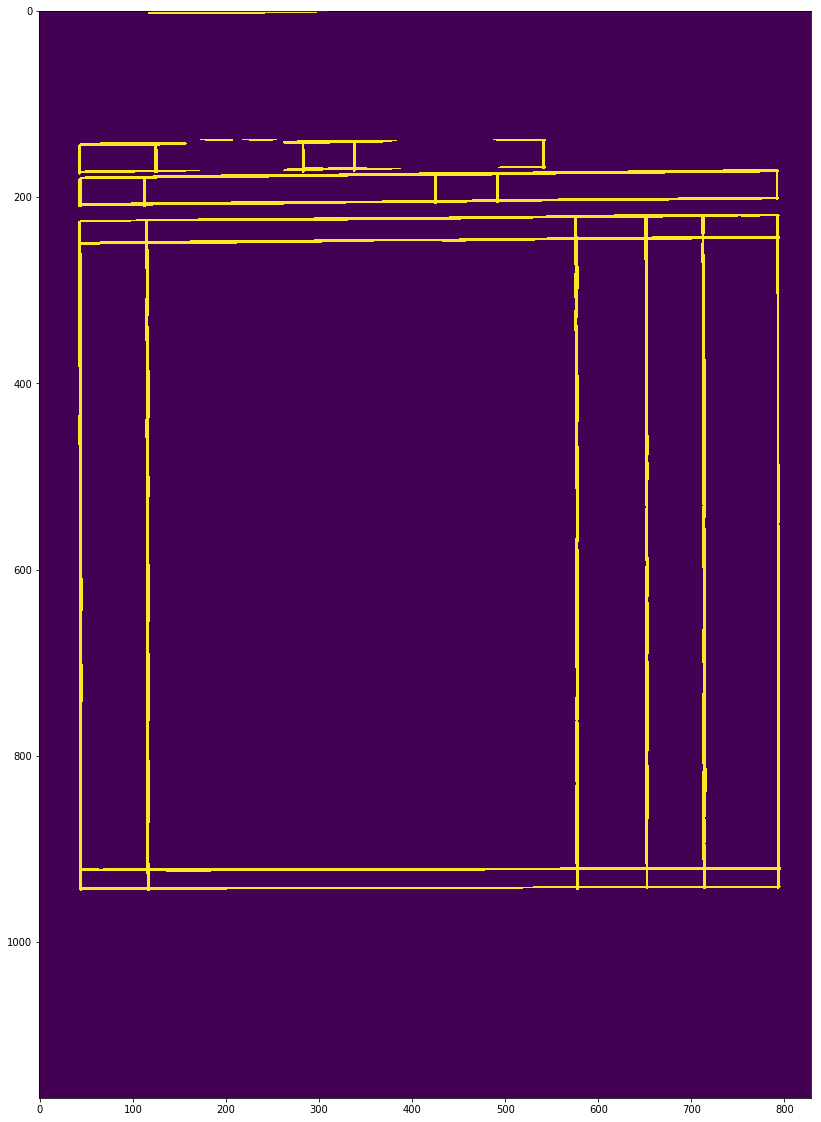

Run time show:  0.46
../data/test/SG1-50-2.png
Run time read_image:  0.10
Run time connect_line:  0.10
Run time connect_line:  0.18


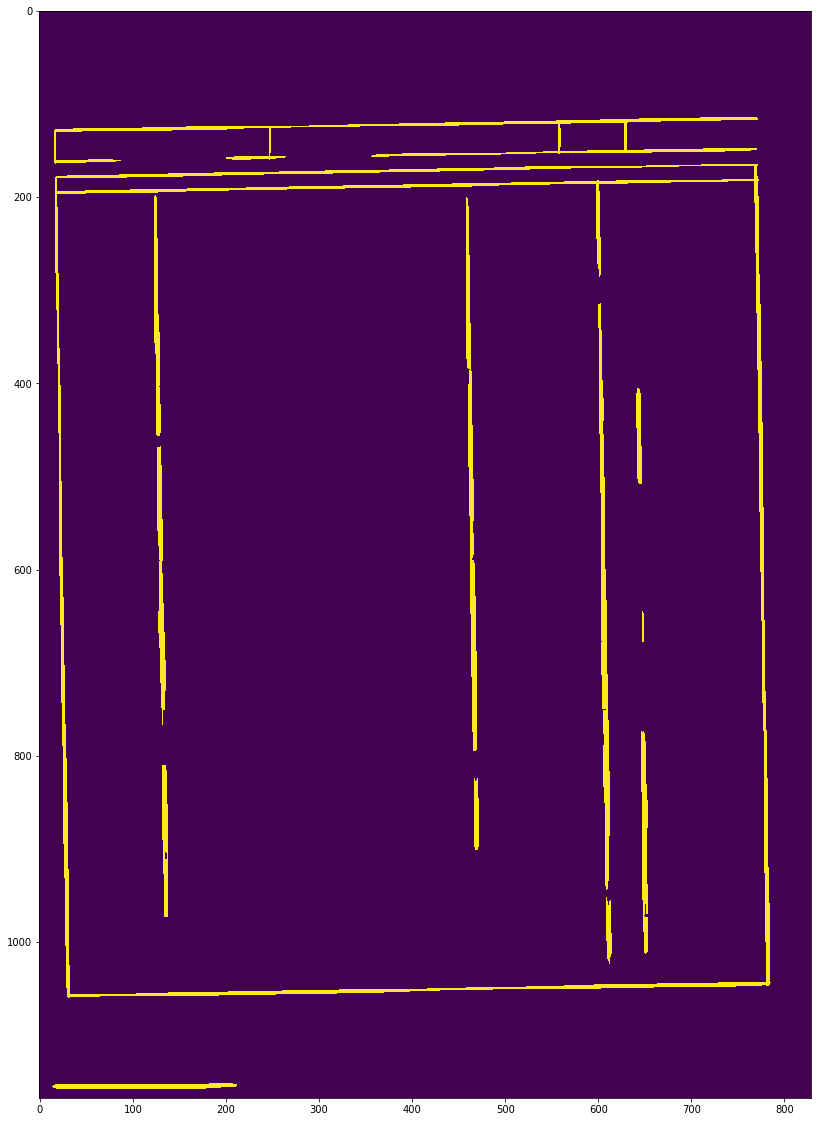

Run time show:  0.42
../data/test/SG1-17.png
Run time read_image:  0.10
Run time connect_line:  0.20
Run time connect_line:  0.27


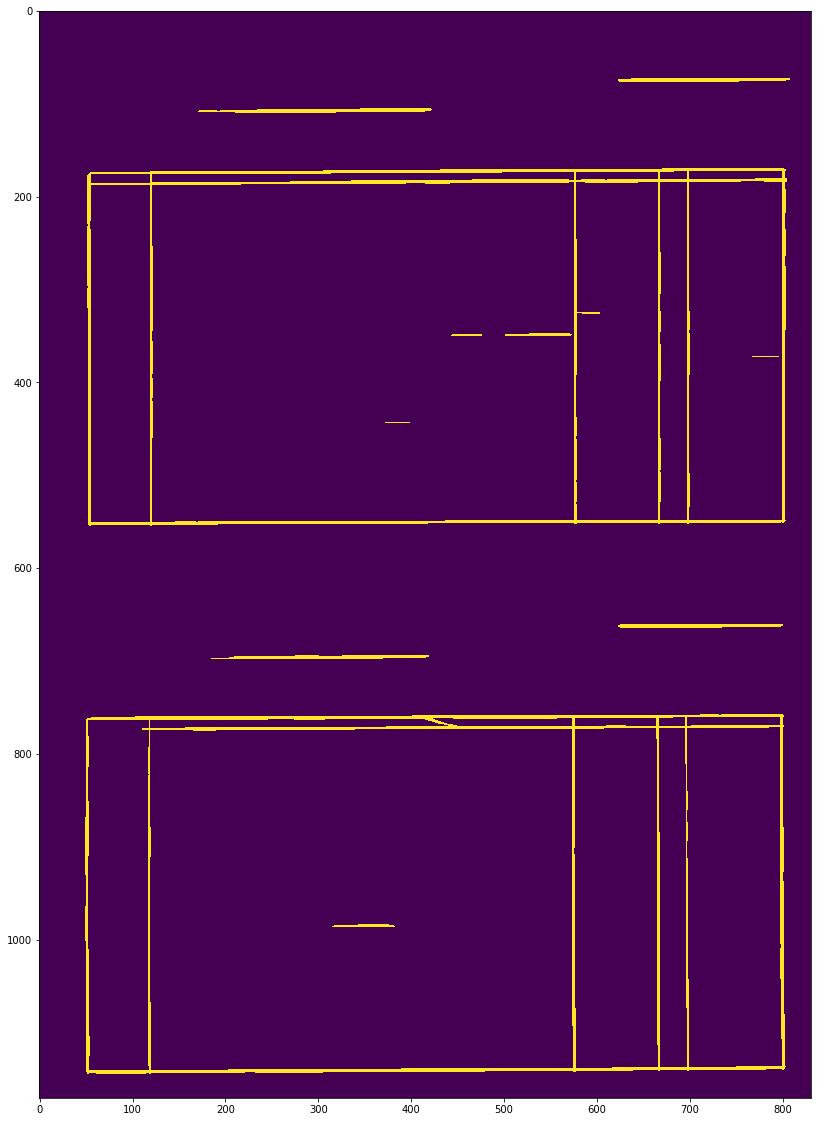

Run time show:  0.42
../data/test/SG1-33-1.png
Run time read_image:  0.09
Run time connect_line:  0.09
Run time connect_line:  0.12


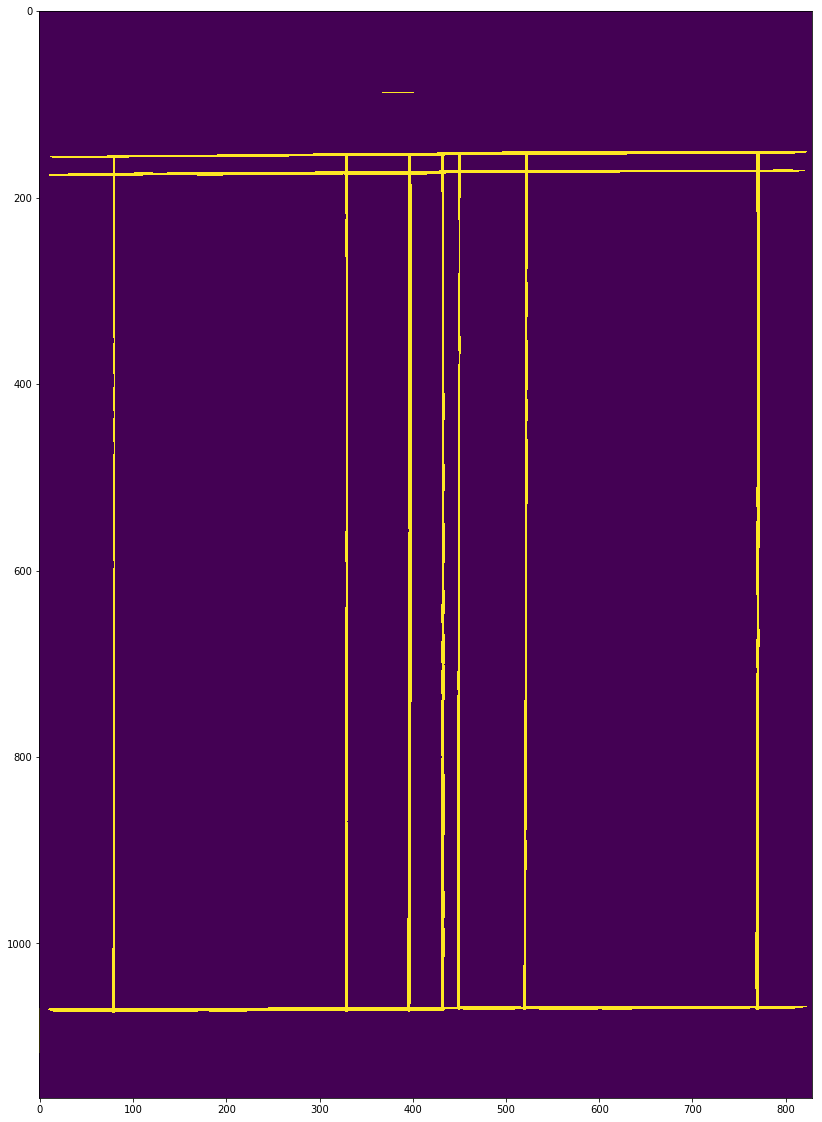

Run time show:  0.46
../data/test/SG1-8.png
Run time read_image:  0.08
Run time connect_line:  0.04
Run time connect_line:  0.09


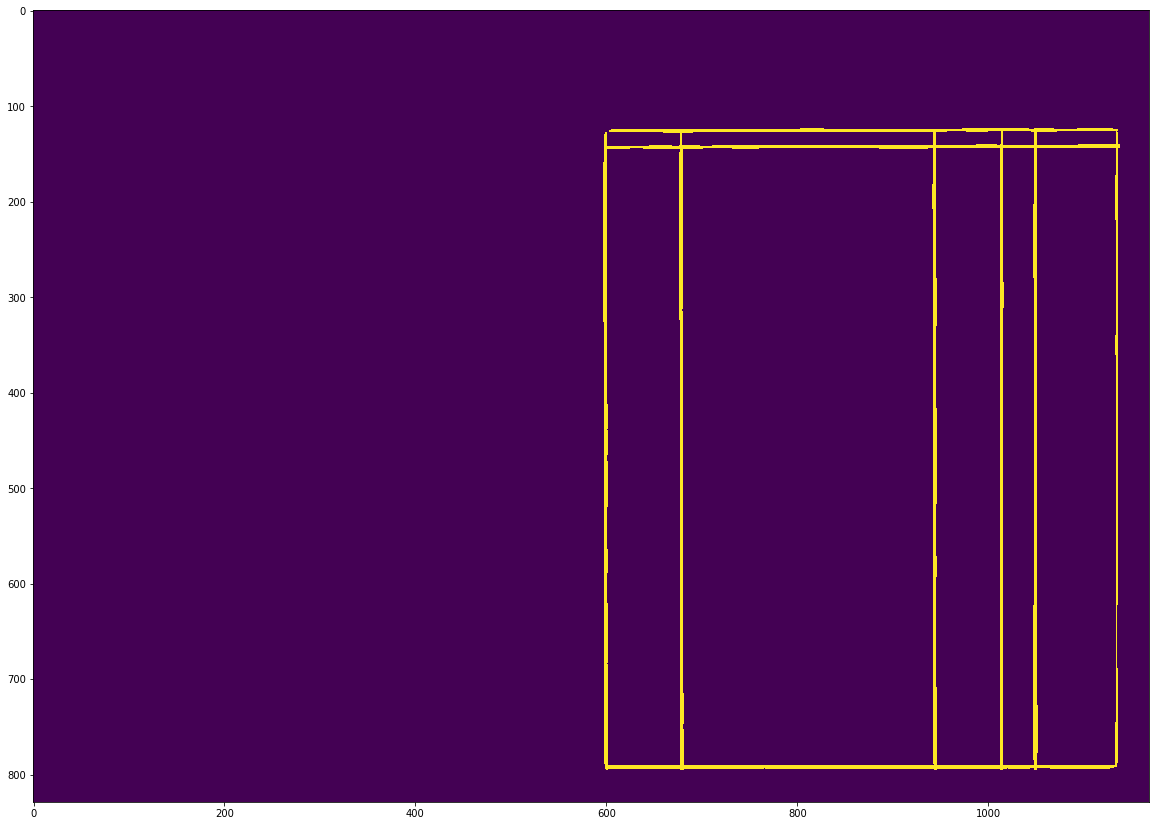

Run time show:  0.43
../data/test/SG1-3-1.png
Run time read_image:  0.06
Run time connect_line:  0.03
Run time connect_line:  0.05


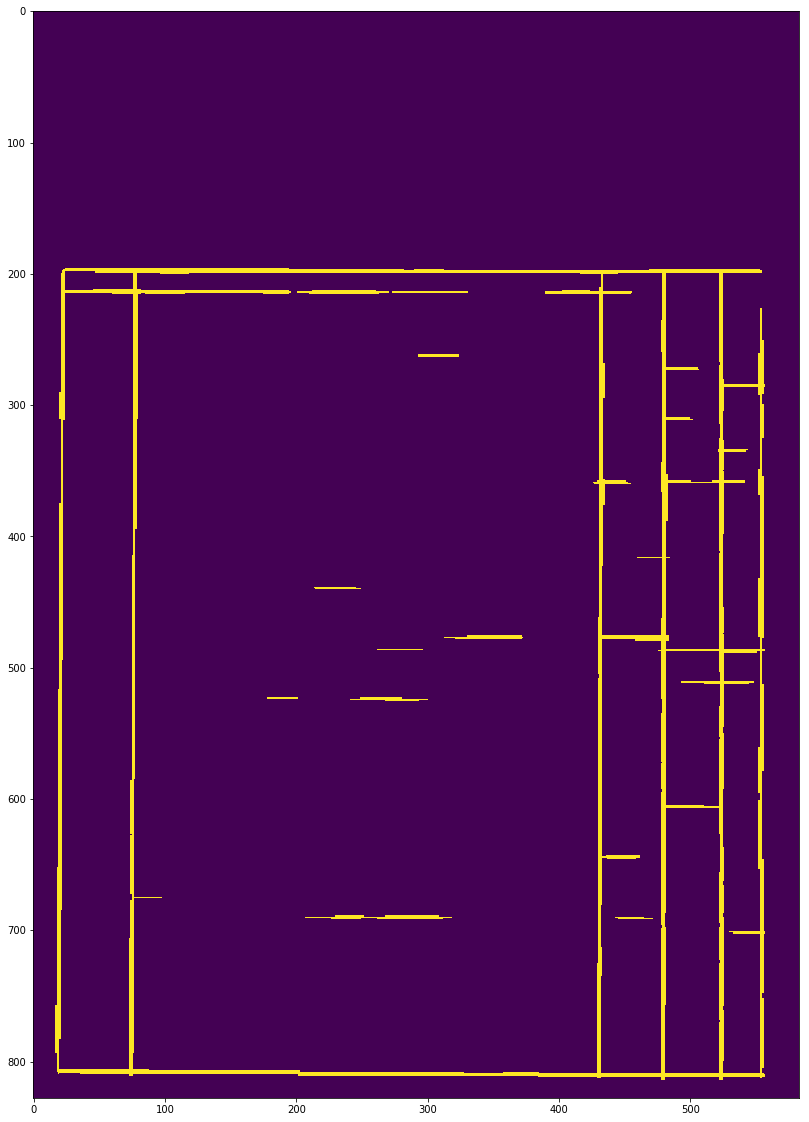

Run time show:  0.48
../data/test/SG1-11.png
Run time read_image:  0.04
Run time connect_line:  0.02
Run time connect_line:  0.02


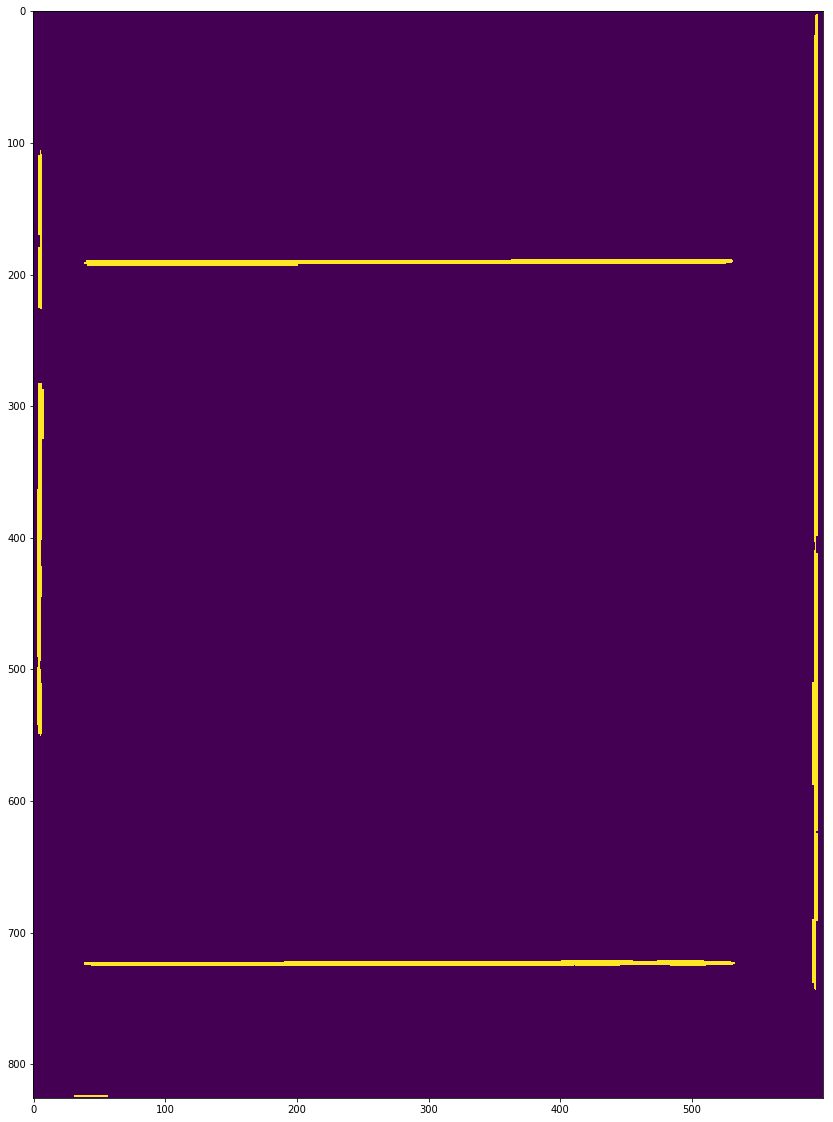

Run time show:  0.45
../data/test/SG1-29.png
Run time read_image:  0.08
Run time connect_line:  0.04
Run time connect_line:  0.09


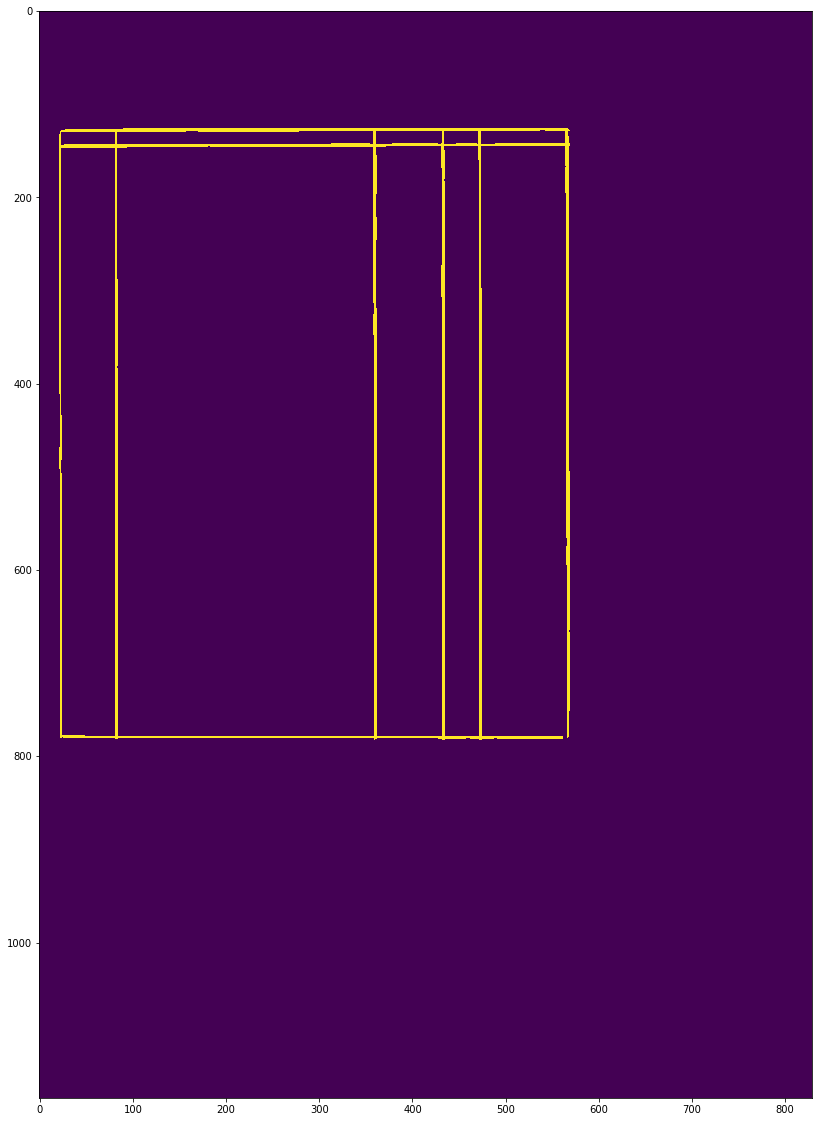

Run time show:  0.46
../data/test/SG1-19.png
Run time read_image:  0.04
Run time connect_line:  0.04
Run time connect_line:  0.05


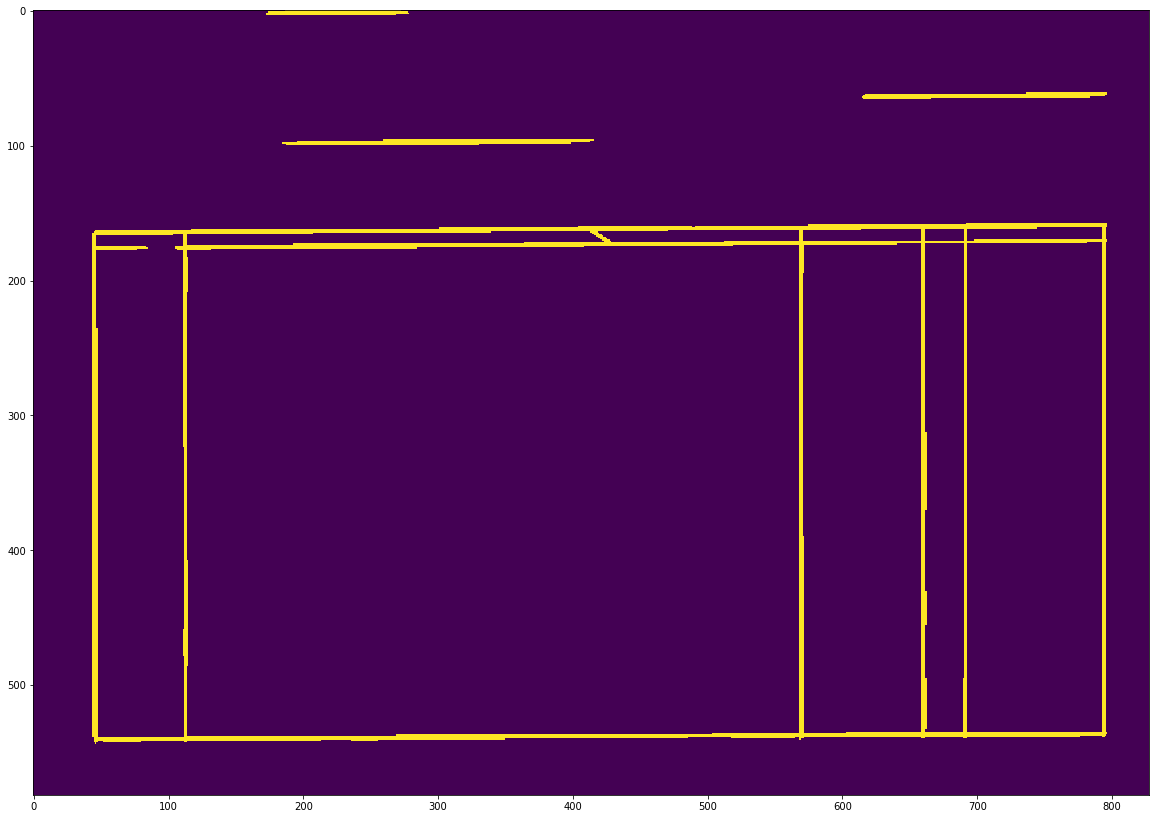

Run time show:  0.45
../data/test/SG1-48-1.png
Run time read_image:  0.10
Run time connect_line:  0.07
Run time connect_line:  0.13


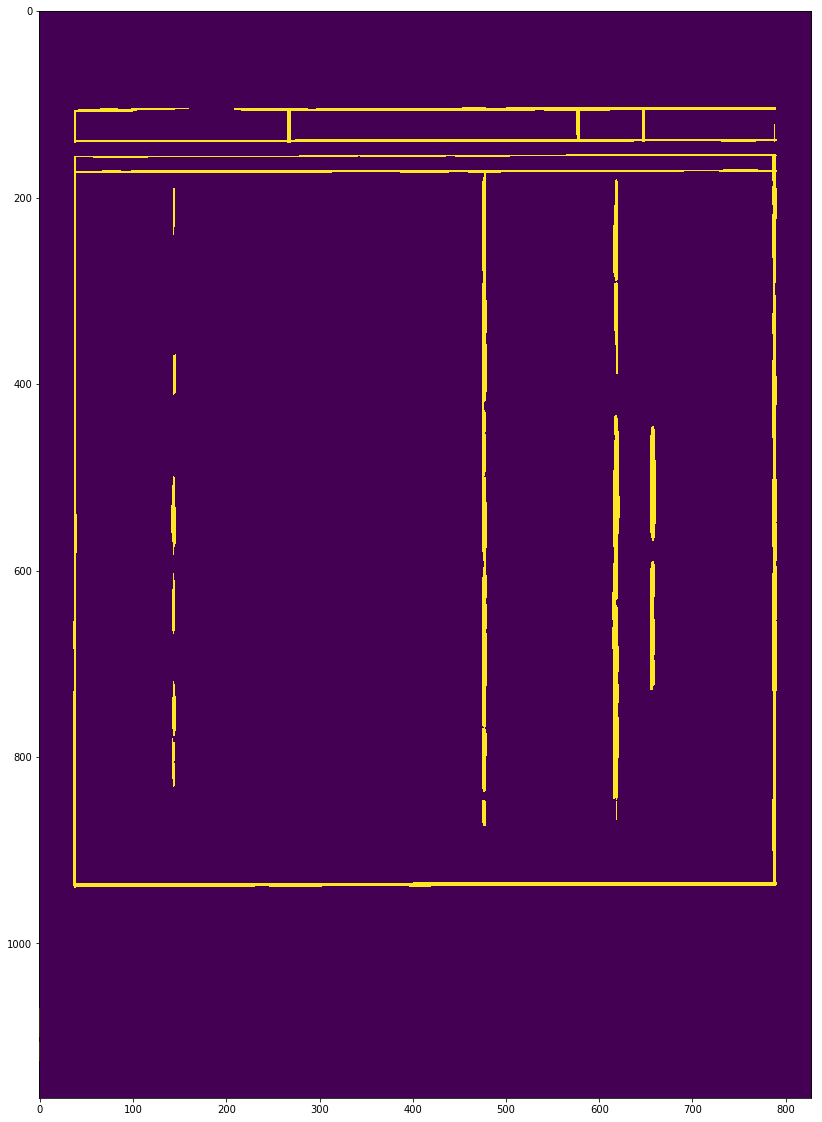

Run time show:  0.46
../data/test/SG1-10-2.png
Run time read_image:  0.10
Run time connect_line:  0.09
Run time connect_line:  0.04


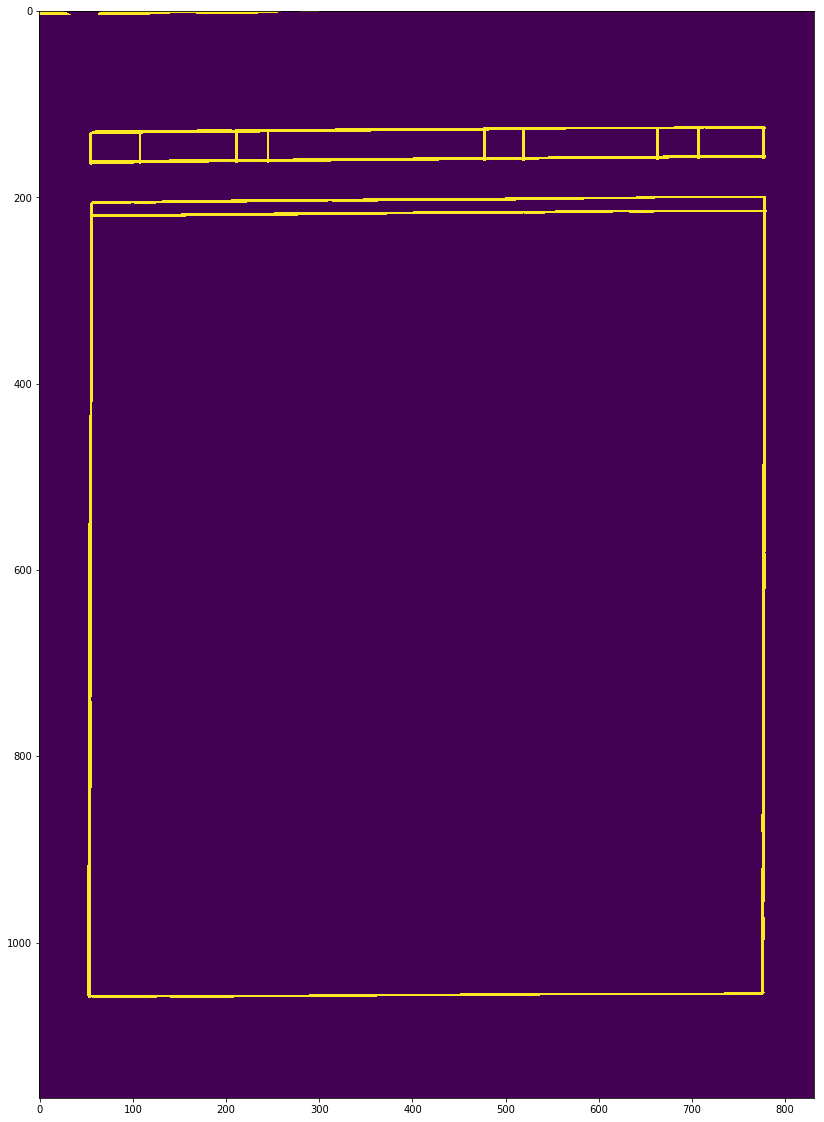

Run time show:  0.46
../data/test/SG1-16.png
Run time read_image:  0.09
Run time connect_line:  0.09
Run time connect_line:  0.11


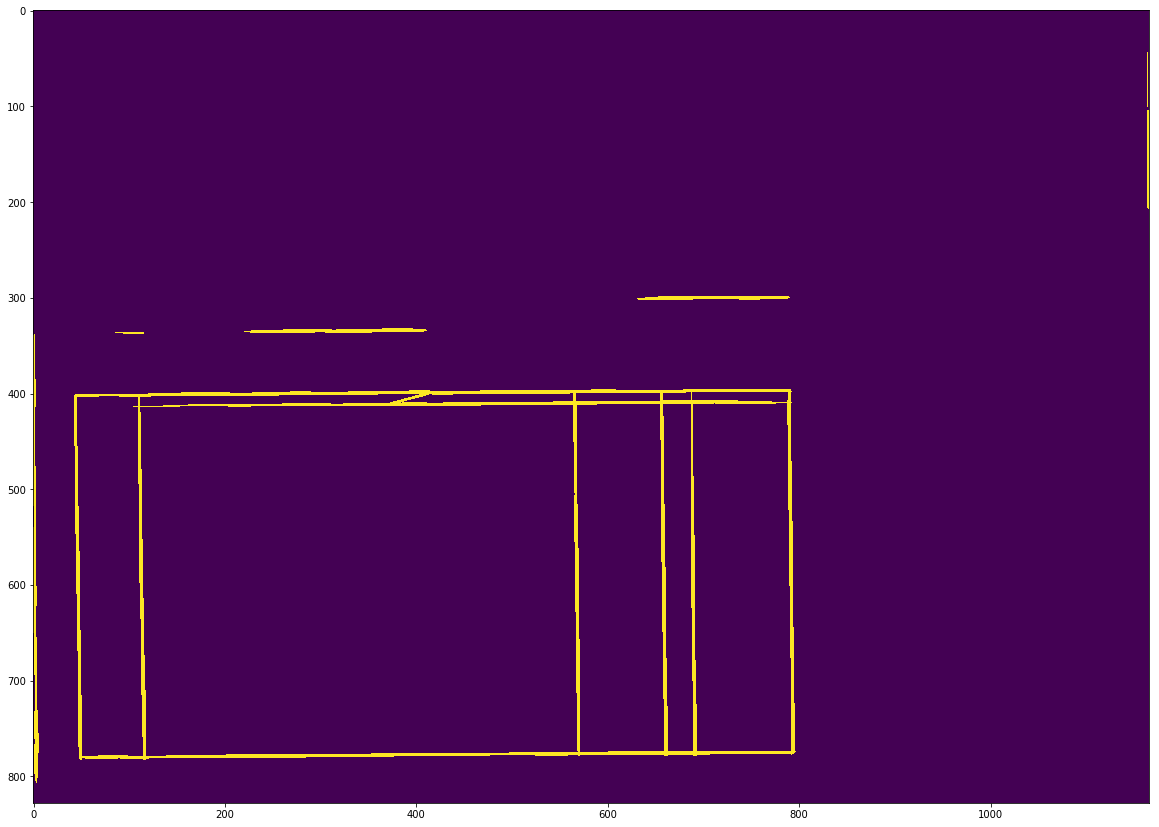

Run time show:  0.46
../data/test/SG1-9-3.png
Run time read_image:  0.10
Run time connect_line:  0.07
Run time connect_line:  0.04


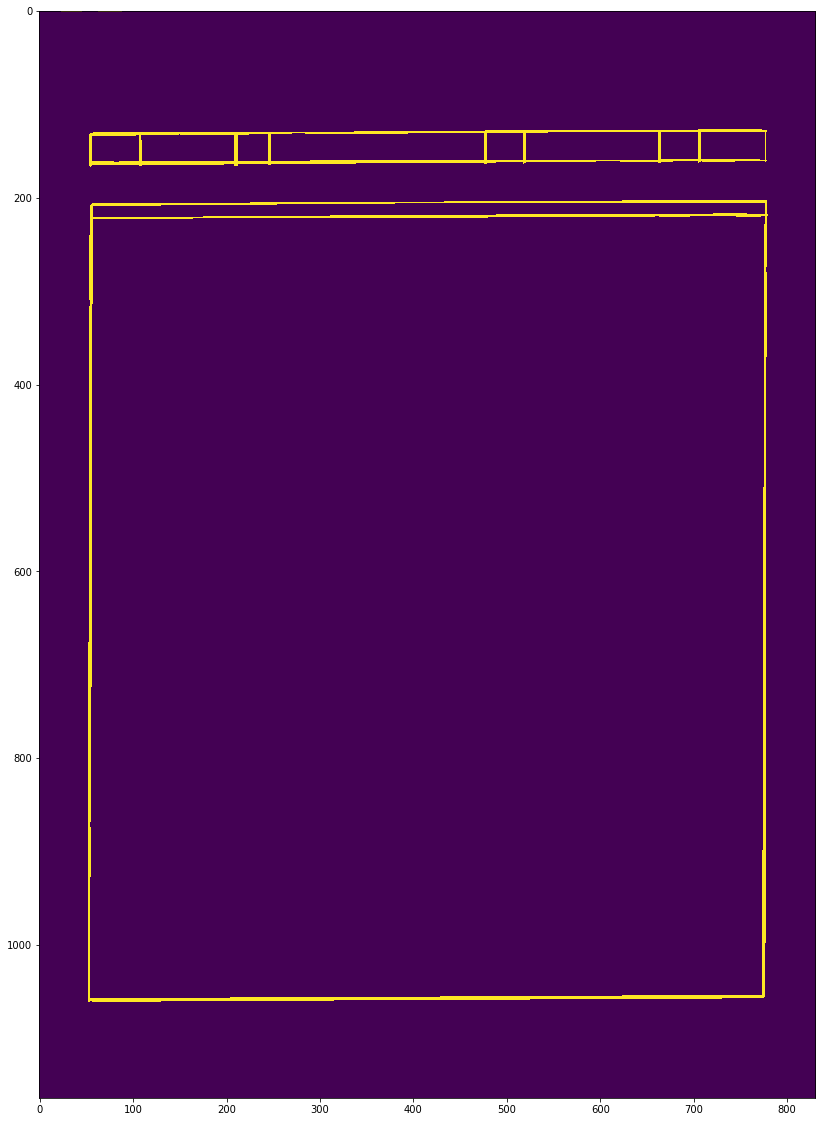

Run time show:  0.46
../data/test/SG1-15.png
Run time read_image:  0.08
Run time connect_line:  0.09
Run time connect_line:  0.06


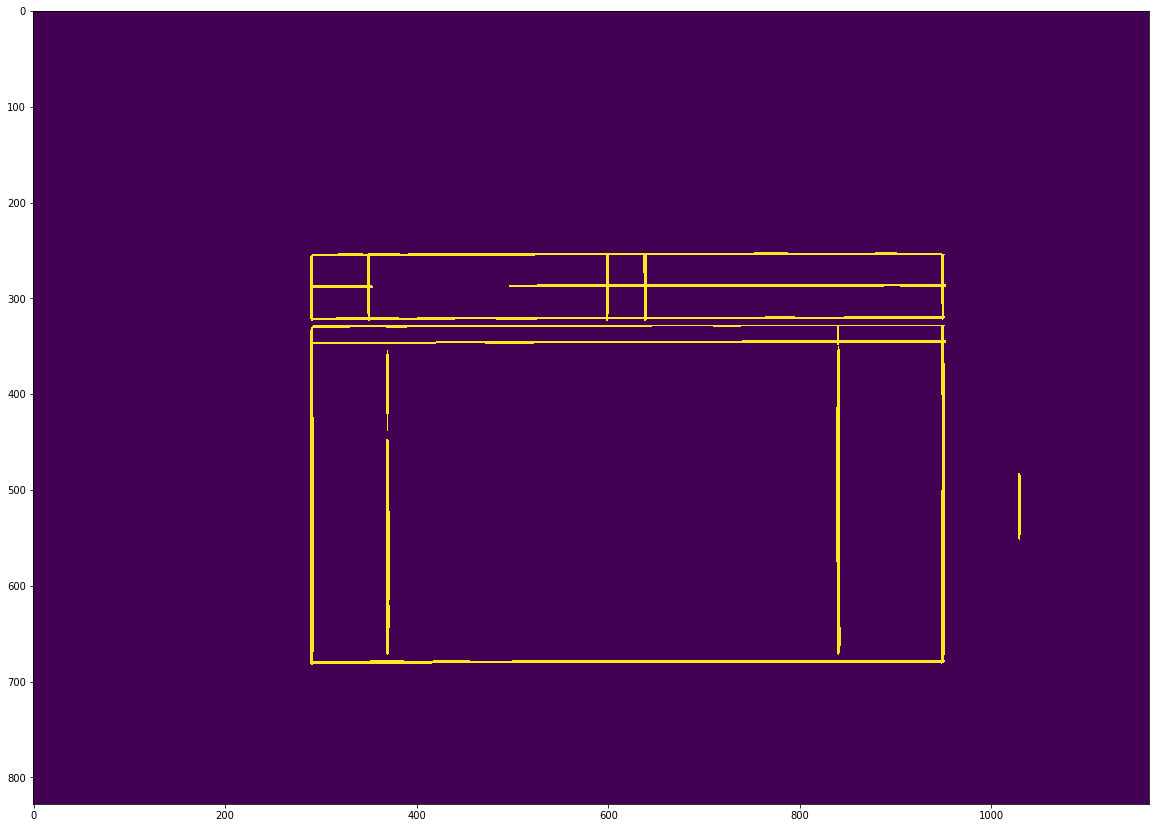

Run time show:  0.46
../data/test/SG1-9-1.png
Run time read_image:  0.09
Run time connect_line:  0.07
Run time connect_line:  0.04


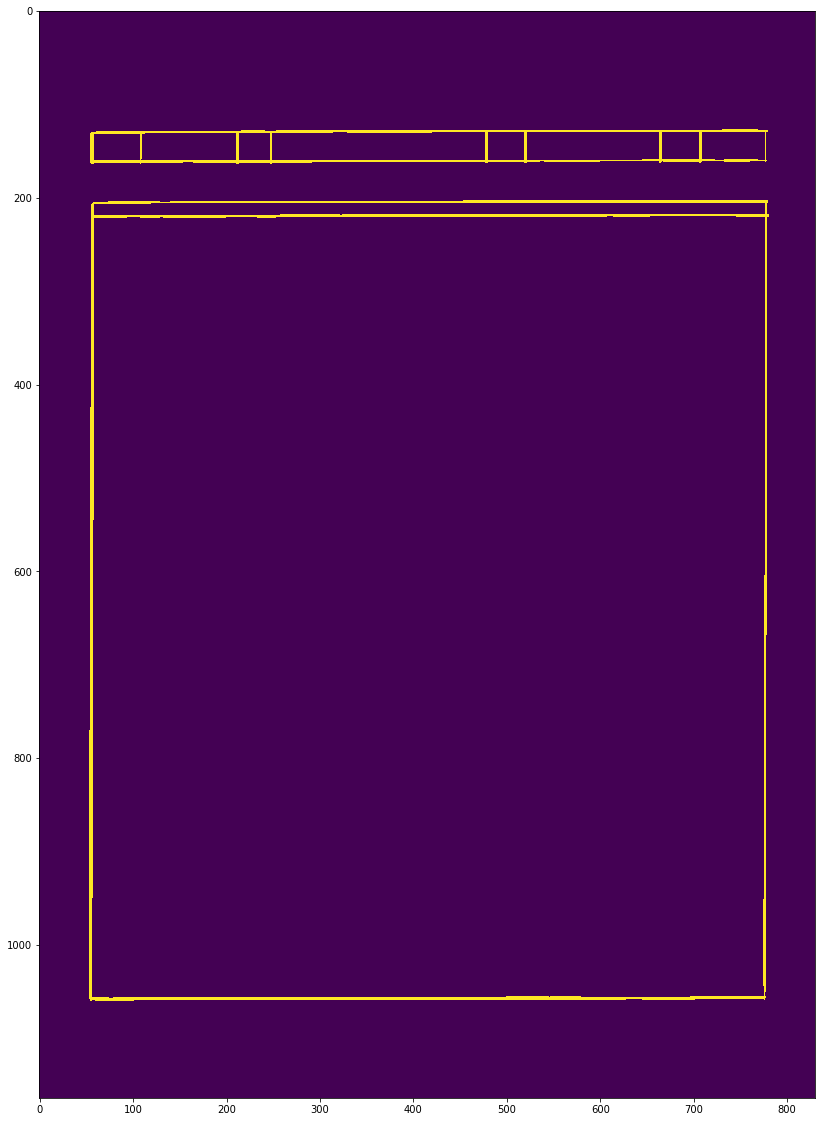

Run time show:  0.46
../data/test/SG1-50-1.png
Run time read_image:  0.10
Run time connect_line:  0.09
Run time connect_line:  0.22


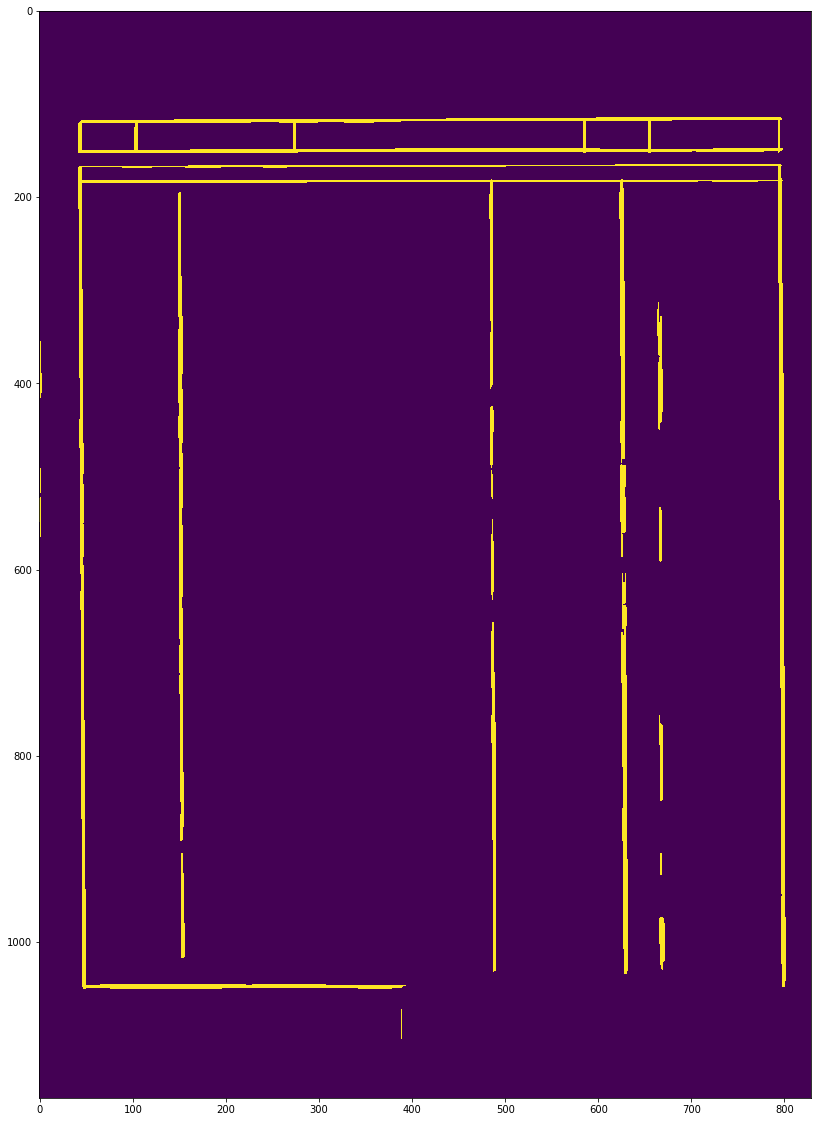

Run time show:  0.44
../data/test/SG1-23.png
Run time read_image:  0.08
Run time connect_line:  0.07
Run time connect_line:  0.04


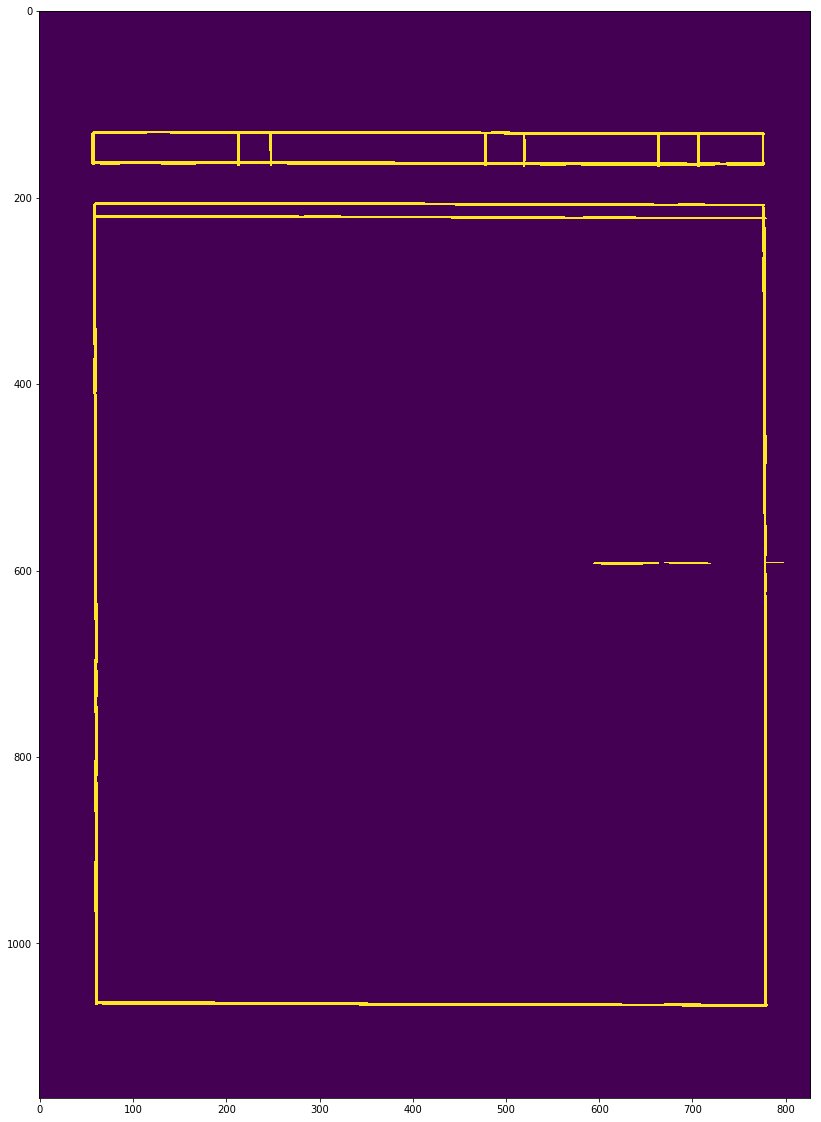

Run time show:  0.49
../data/test/SG1-33-2.png
Run time read_image:  0.08
Run time connect_line:  0.11
Run time connect_line:  0.12


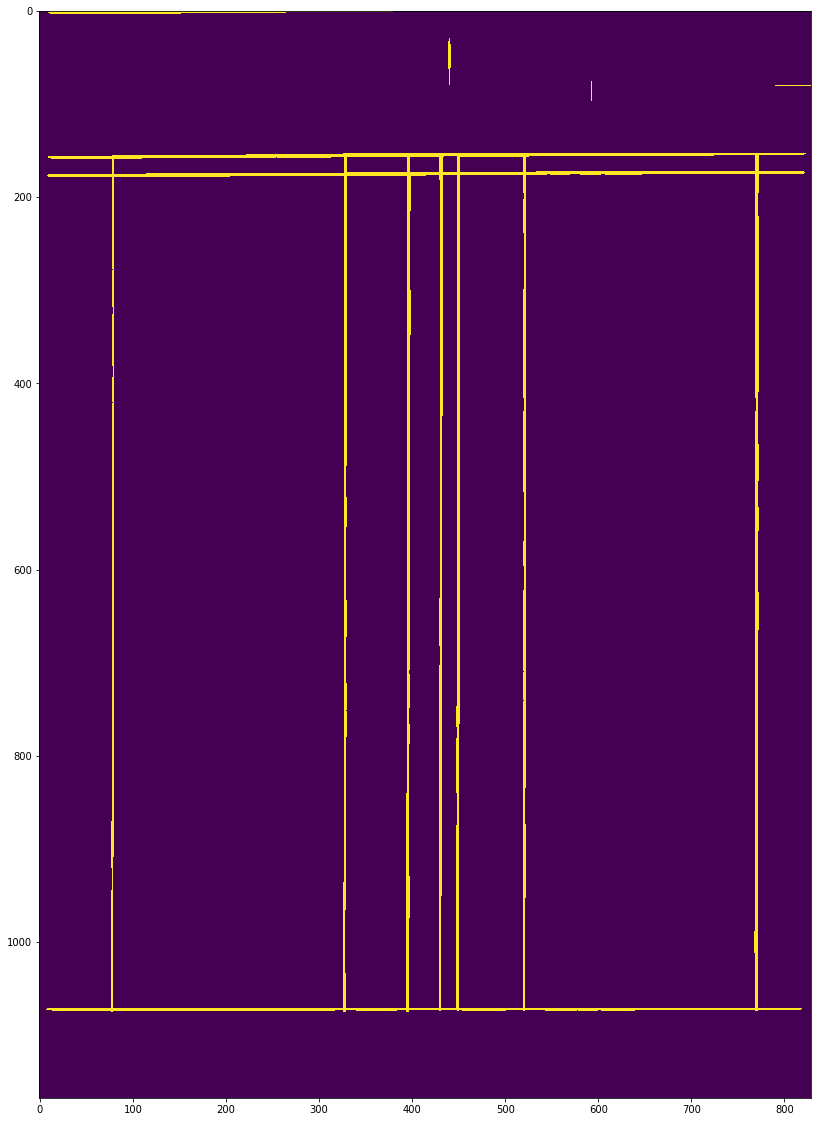

Run time show:  0.46
../data/test/SG1-1-3.png
Run time read_image:  0.10
Run time connect_line:  0.14
Run time connect_line:  0.18


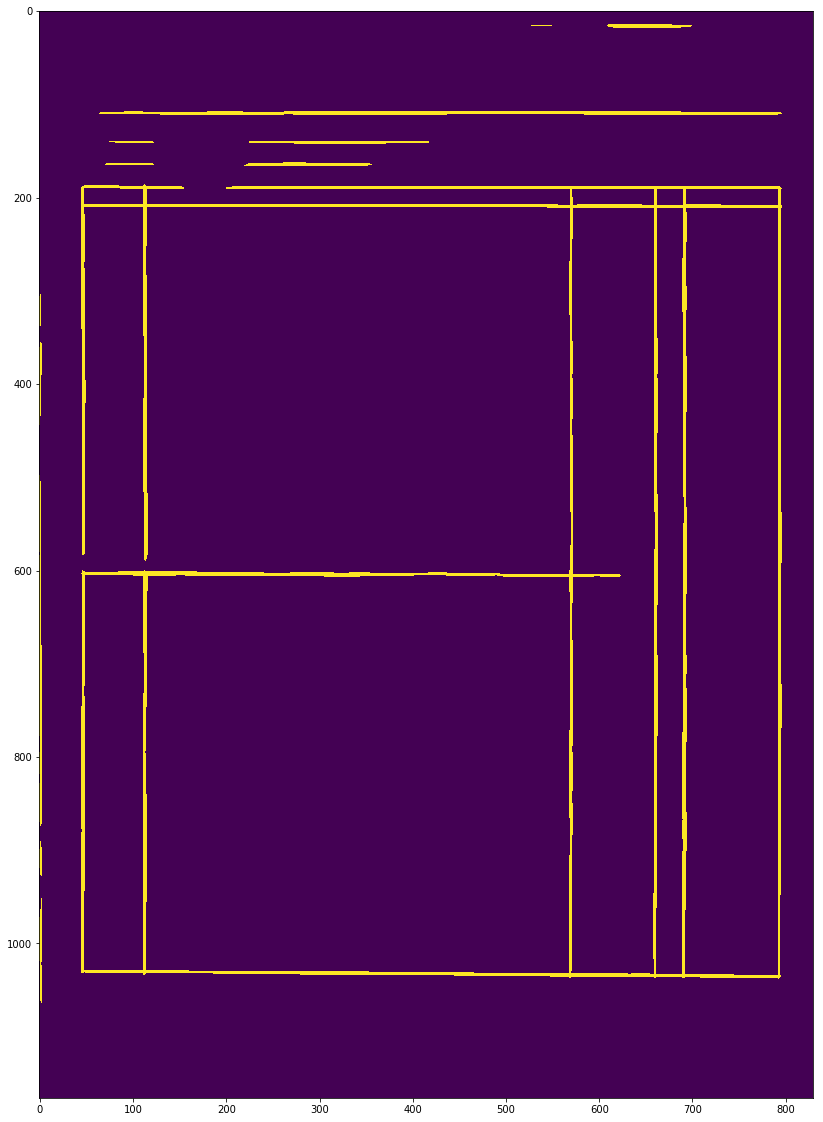

Run time show:  0.46
../data/test/SG1-37.png
Run time read_image:  0.10
Run time connect_line:  0.16
Run time connect_line:  0.09


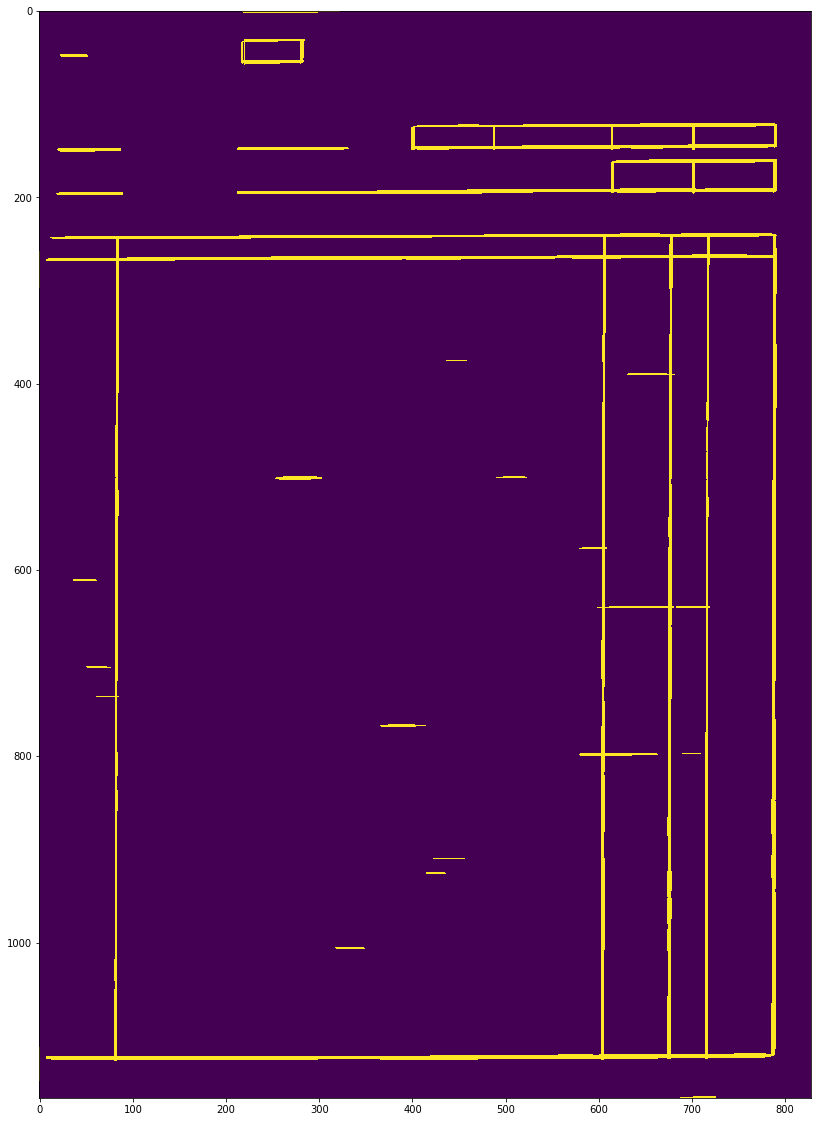

Run time show:  0.42
../data/test/SG1-36.png
Run time read_image:  0.10
Run time connect_line:  0.21
Run time connect_line:  0.09


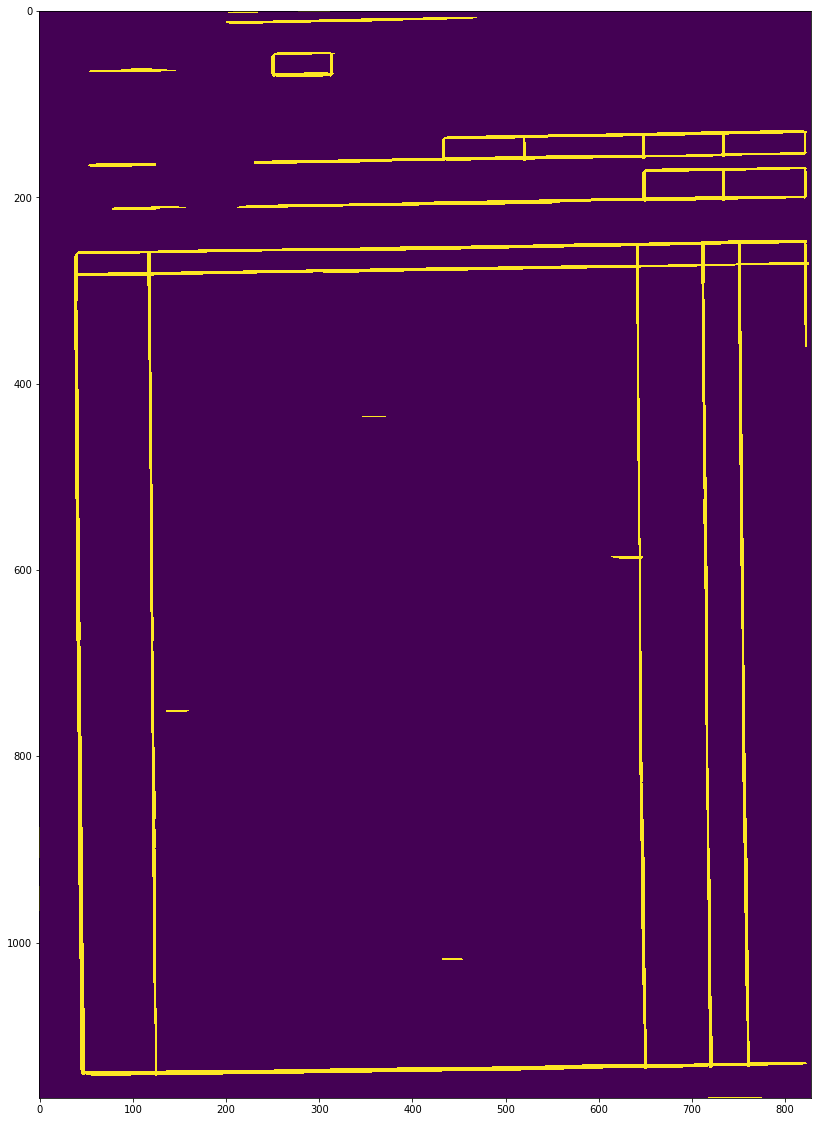

Run time show:  0.46
../data/test/SG1-9-2.png
Run time read_image:  0.10
Run time connect_line:  0.09
Run time connect_line:  0.04


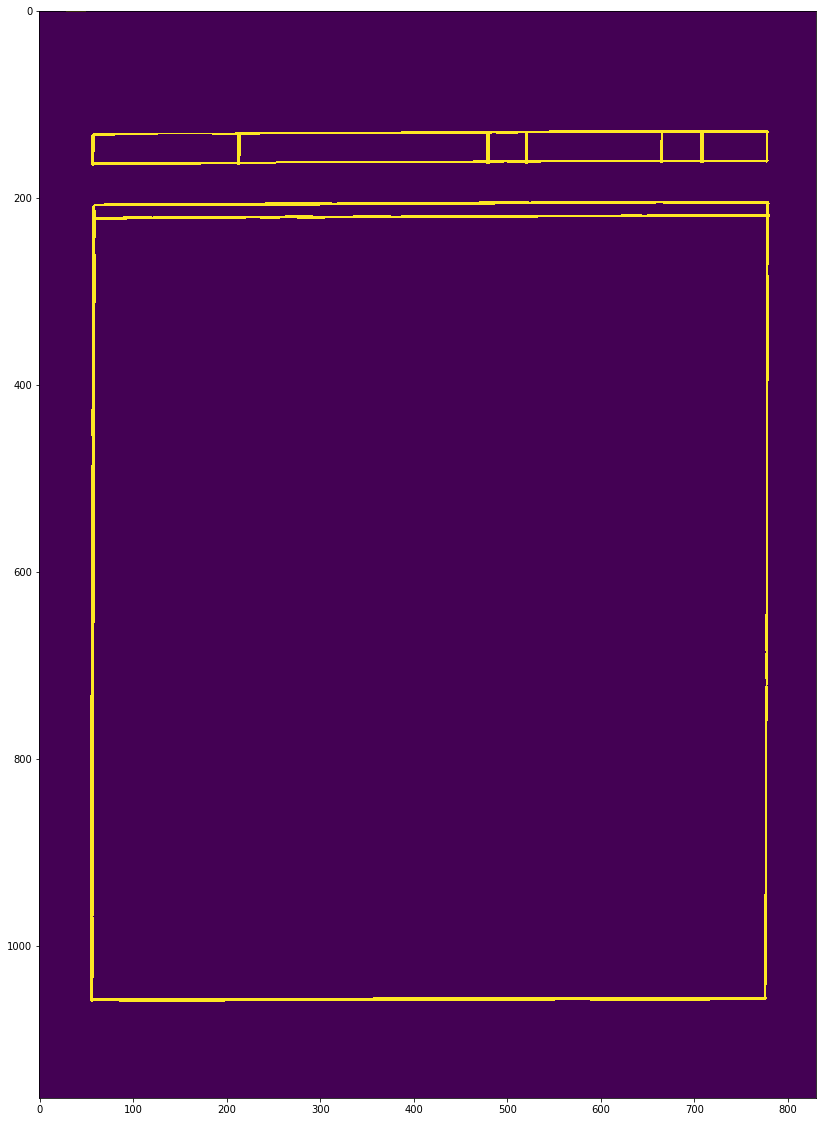

Run time show:  0.46
../data/test/SG1-40-2.png
Run time read_image:  0.11
Run time connect_line:  0.15
Run time connect_line:  0.11


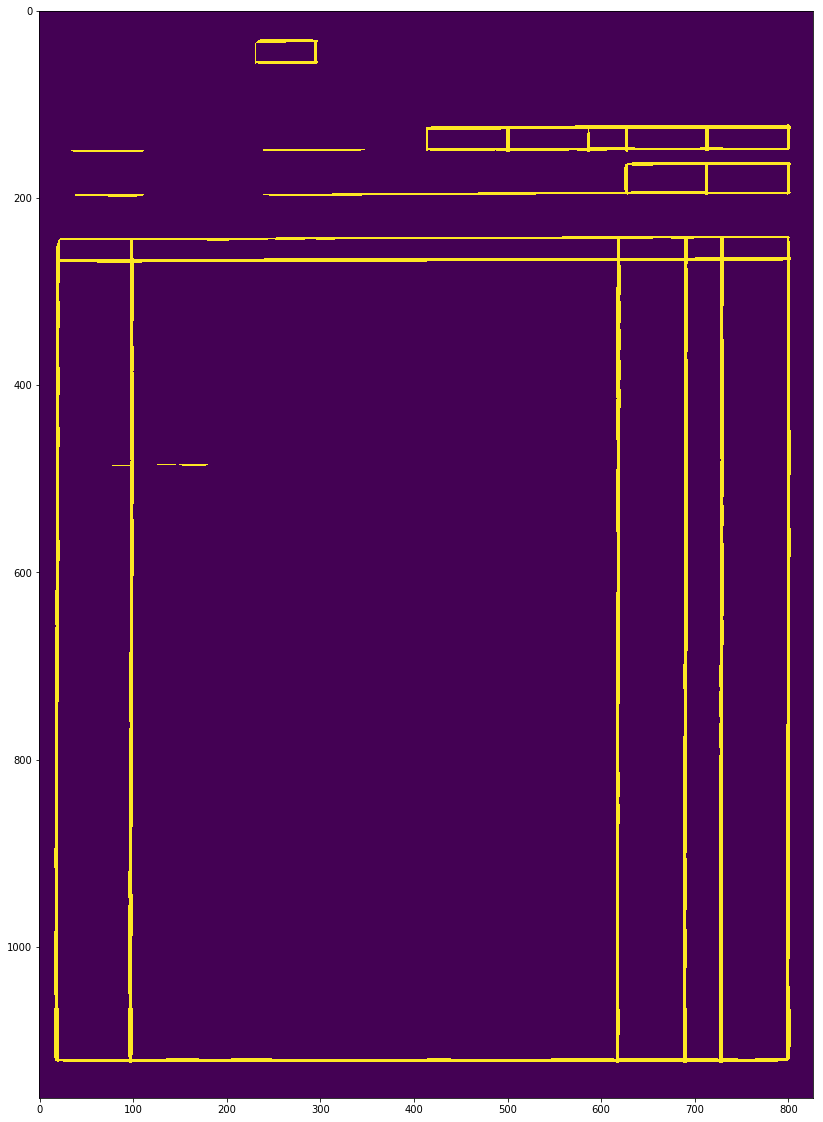

Run time show:  0.42
../data/test/SG1-12.png
Run time read_image:  0.06
Run time connect_line:  0.60
Run time connect_line:  0.03


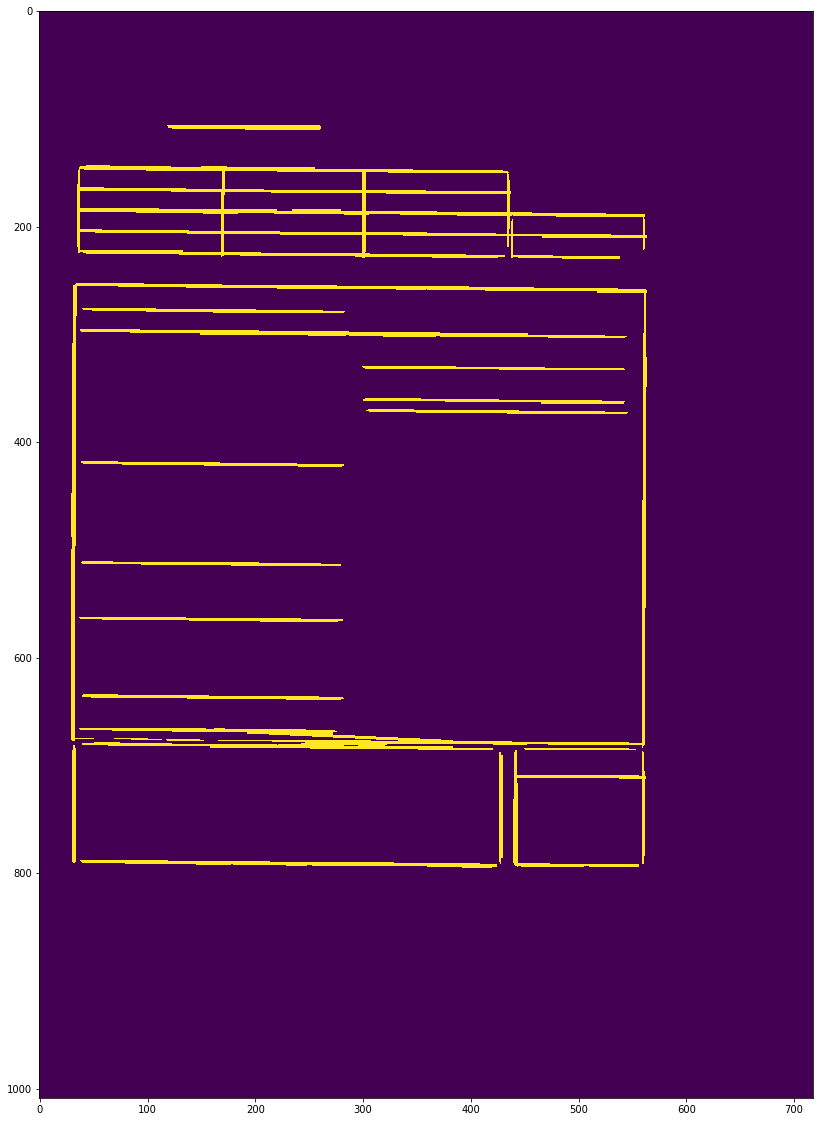

Run time show:  0.45
../data/test/SG1-7.png
Run time read_image:  0.05
Run time connect_line:  0.03
Run time connect_line:  0.07


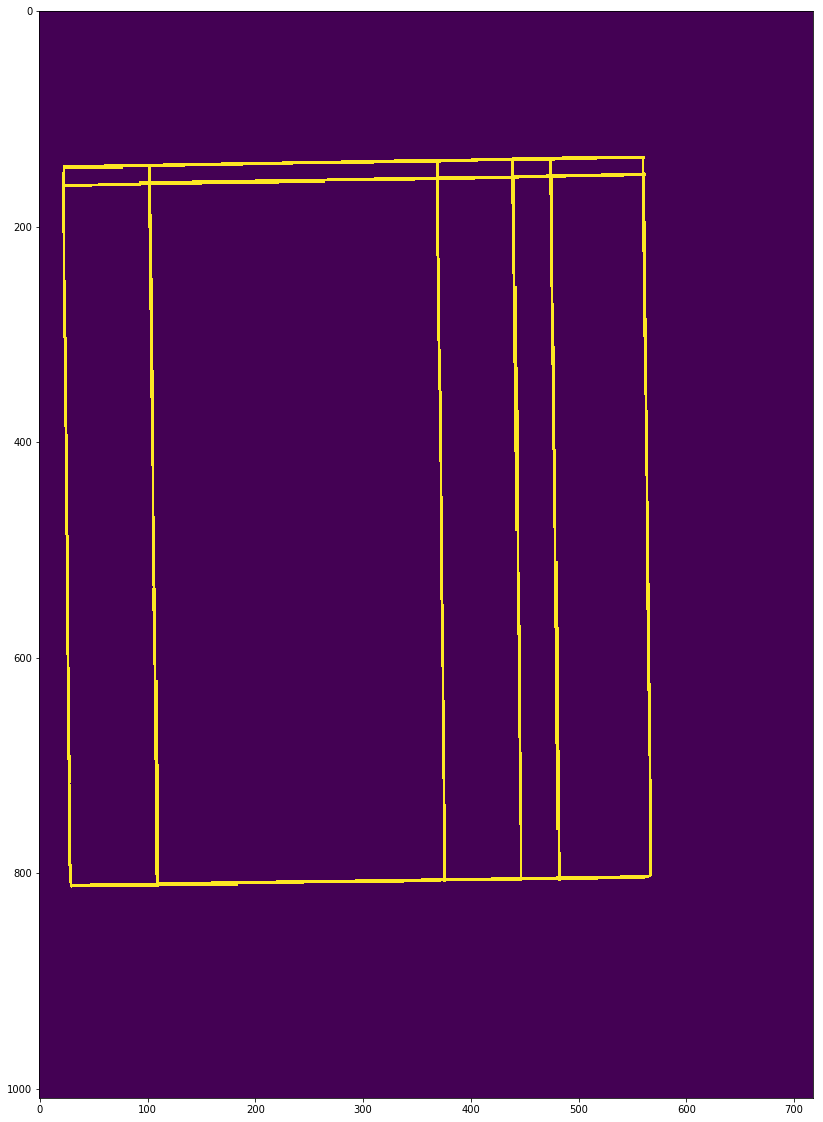

Run time show:  0.45
../data/test/SG1-26.png
Run time read_image:  0.09
Run time connect_line:  0.15
Run time connect_line:  0.12


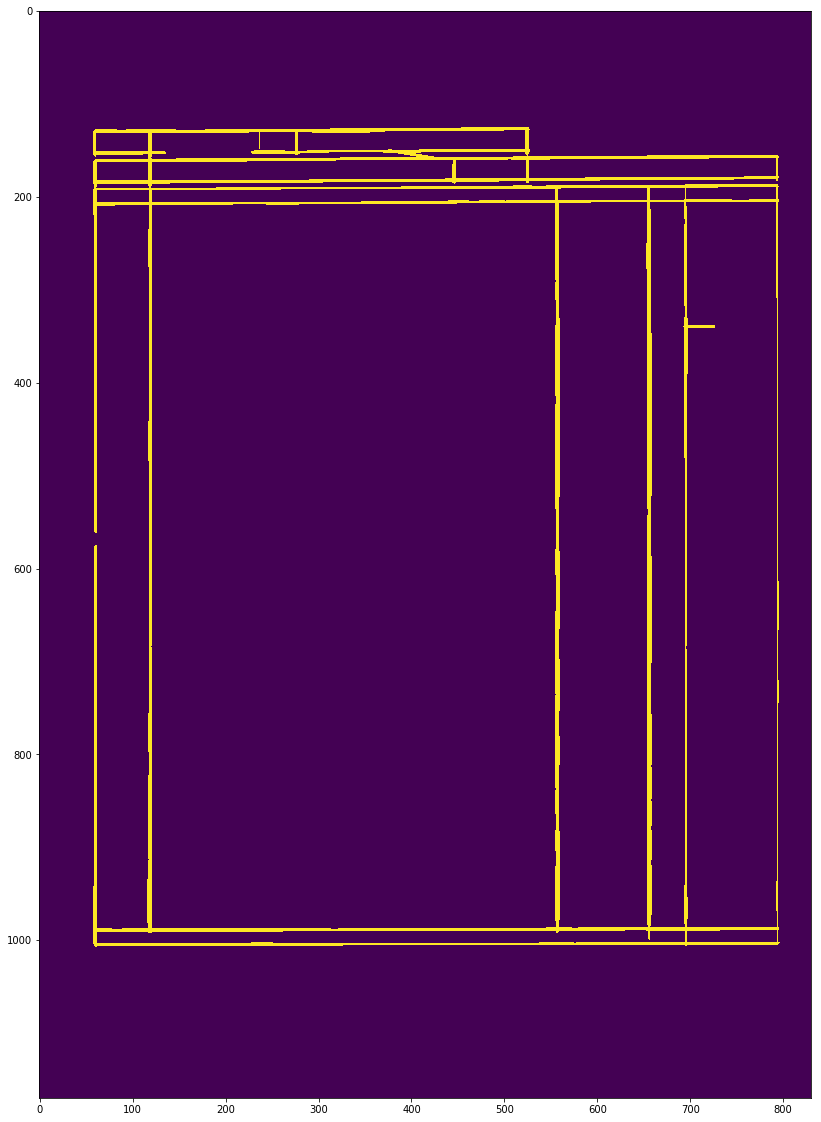

Run time show:  0.46
../data/test/SG1-30.png
Run time read_image:  0.08
Run time connect_line:  0.03
Run time connect_line:  0.07


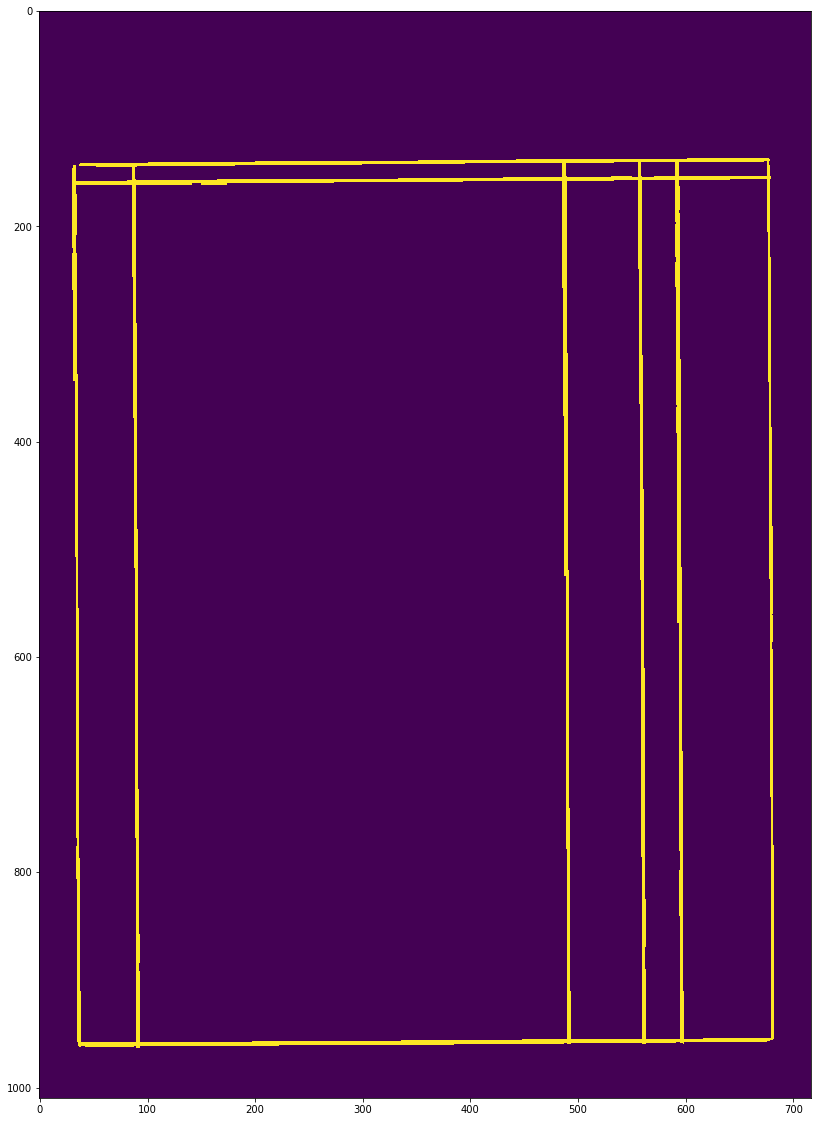

Run time show:  0.45
../data/test/SG1-49.png
Run time read_image:  0.08
Run time connect_line:  0.07
Run time connect_line:  0.04


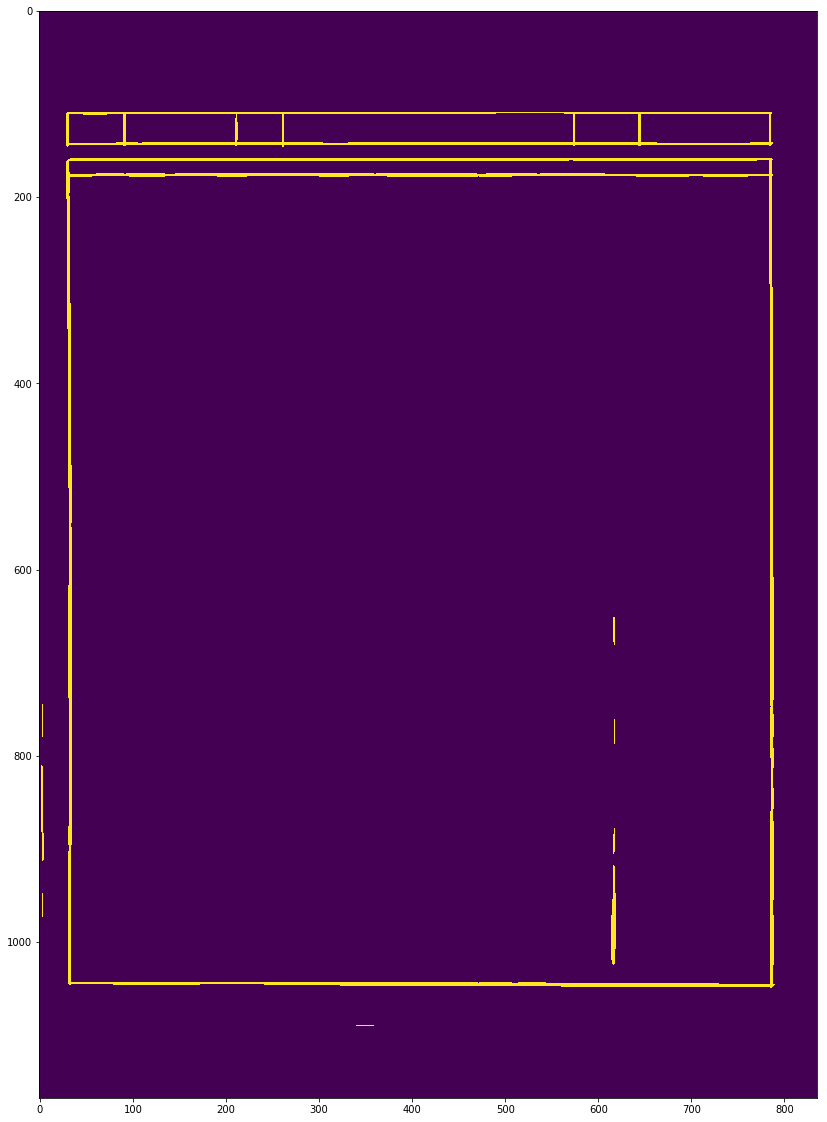

Run time show:  0.49
../data/test/SG1-45.png
Run time read_image:  0.08
Run time connect_line:  0.07
Run time connect_line:  0.10


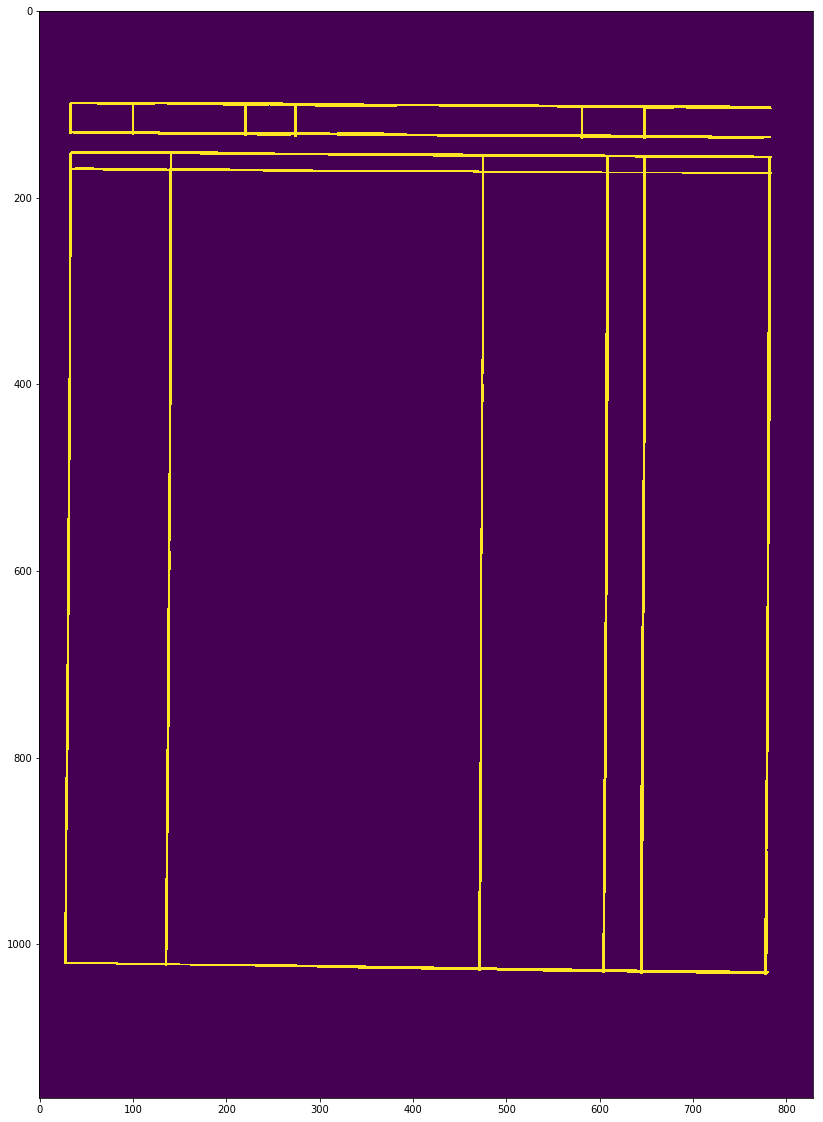

Run time show:  0.46
../data/test/SG1-24-1.png
Run time read_image:  0.09
Run time connect_line:  0.05
Run time connect_line:  0.07


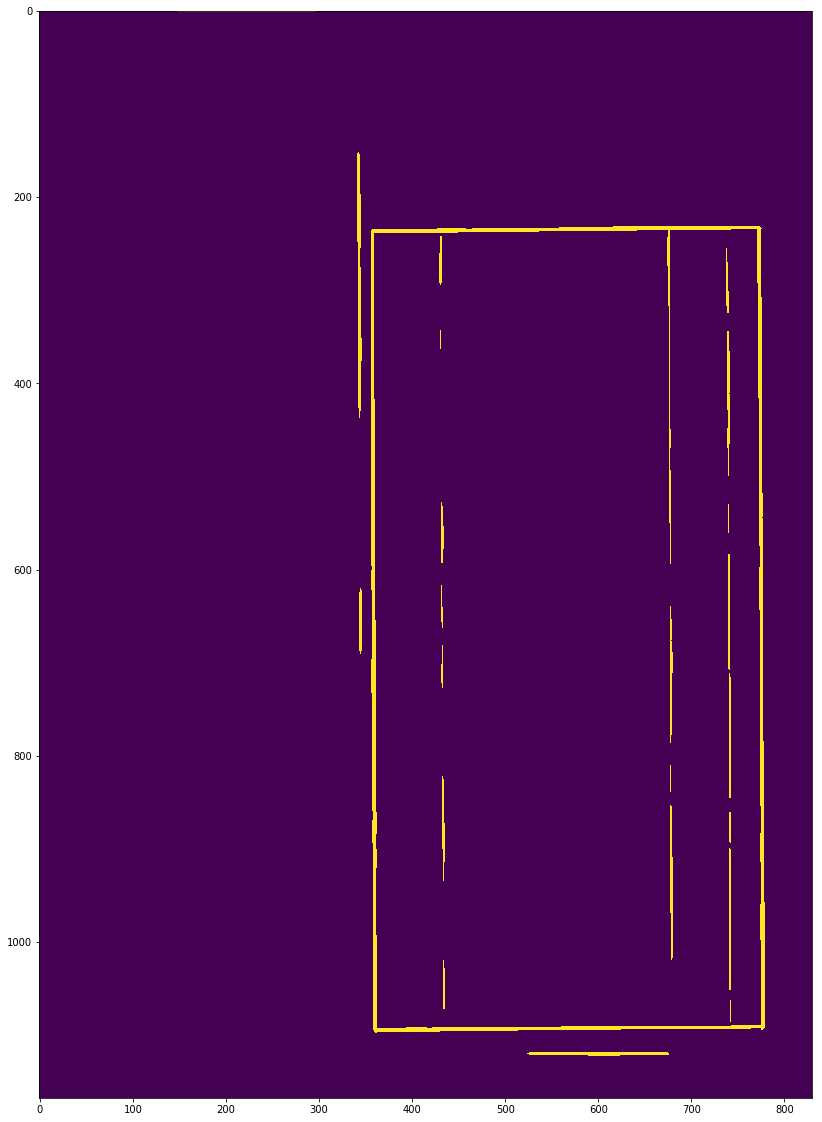

Run time show:  0.46
../data/test/SG1-43.png
Run time read_image:  0.06
Run time connect_line:  0.04
Run time connect_line:  0.08


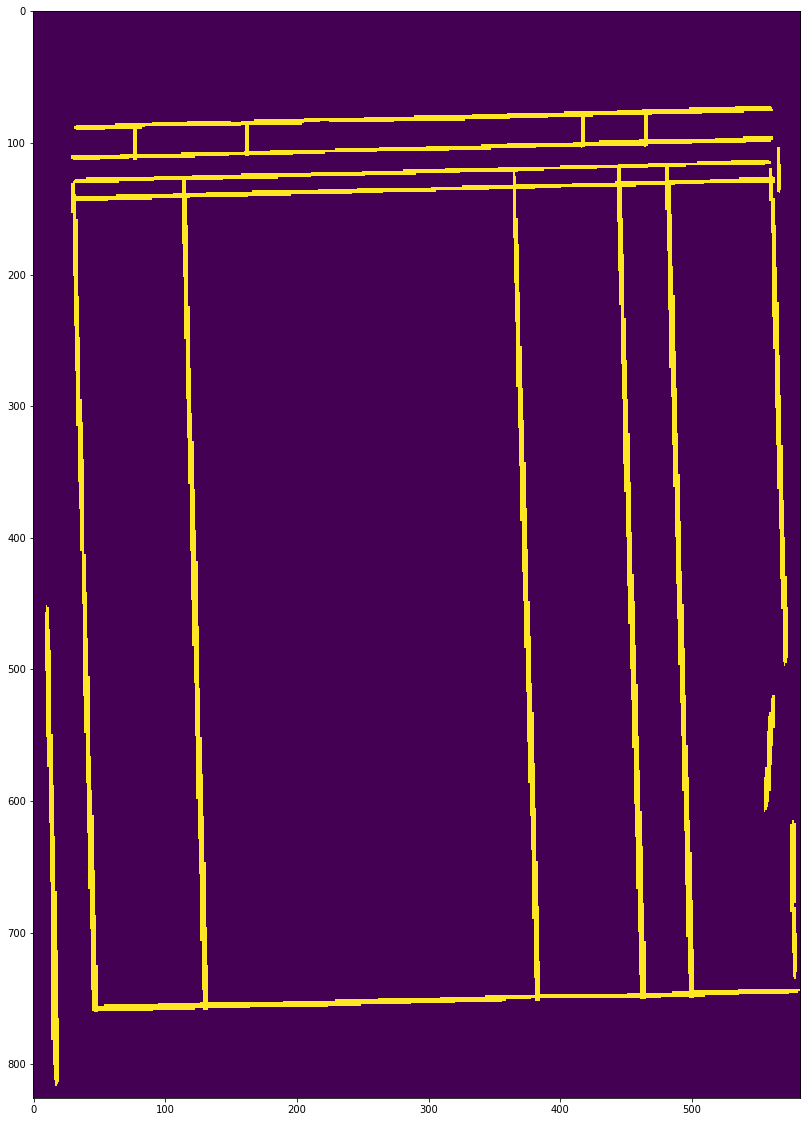

Run time show:  0.44
../data/test/SG1-35.png
Run time read_image:  0.05
Run time connect_line:  0.03
Run time connect_line:  0.07


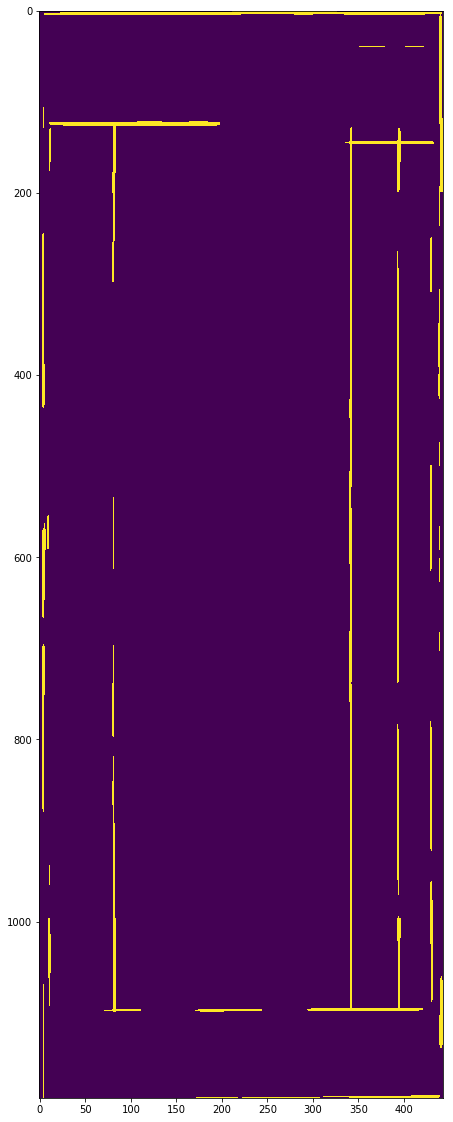

Run time show:  0.38
../data/test/SG1-4.png
Run time read_image:  0.04
Run time connect_line:  0.03
Run time connect_line:  0.05


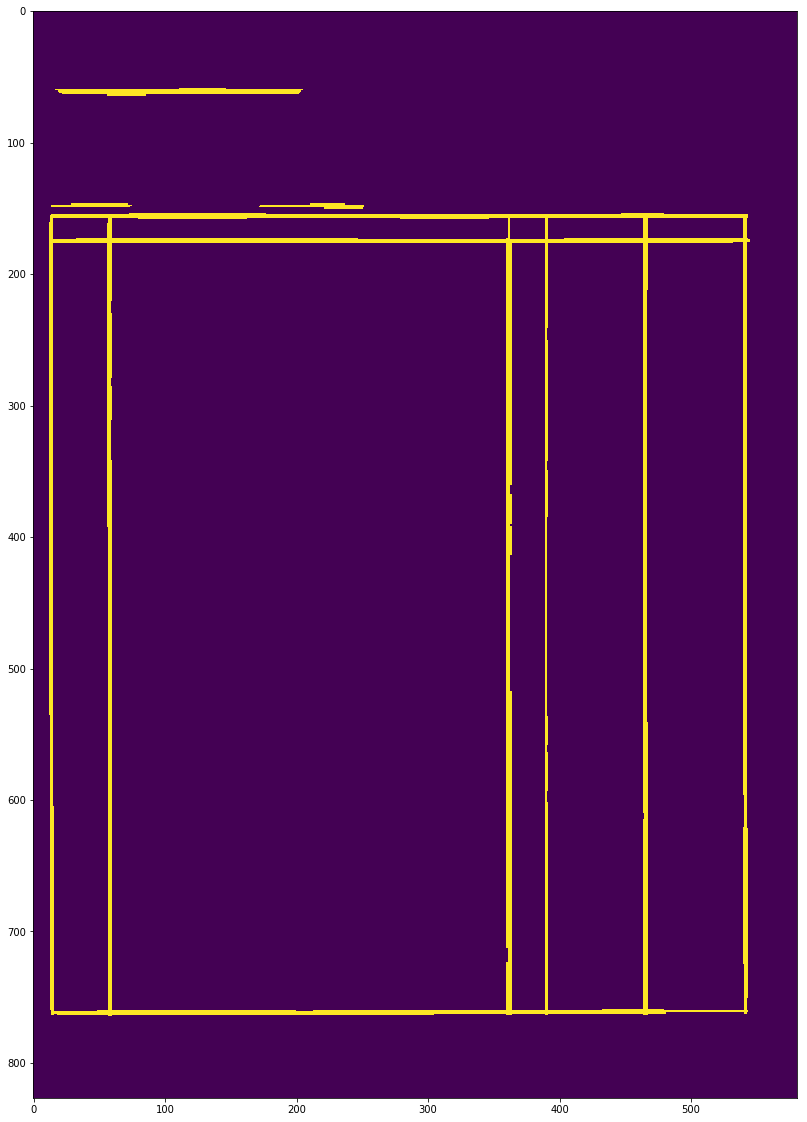

Run time show:  0.45
../data/test/SG1-38.png
Run time read_image:  0.09
Run time connect_line:  0.14
Run time connect_line:  0.10


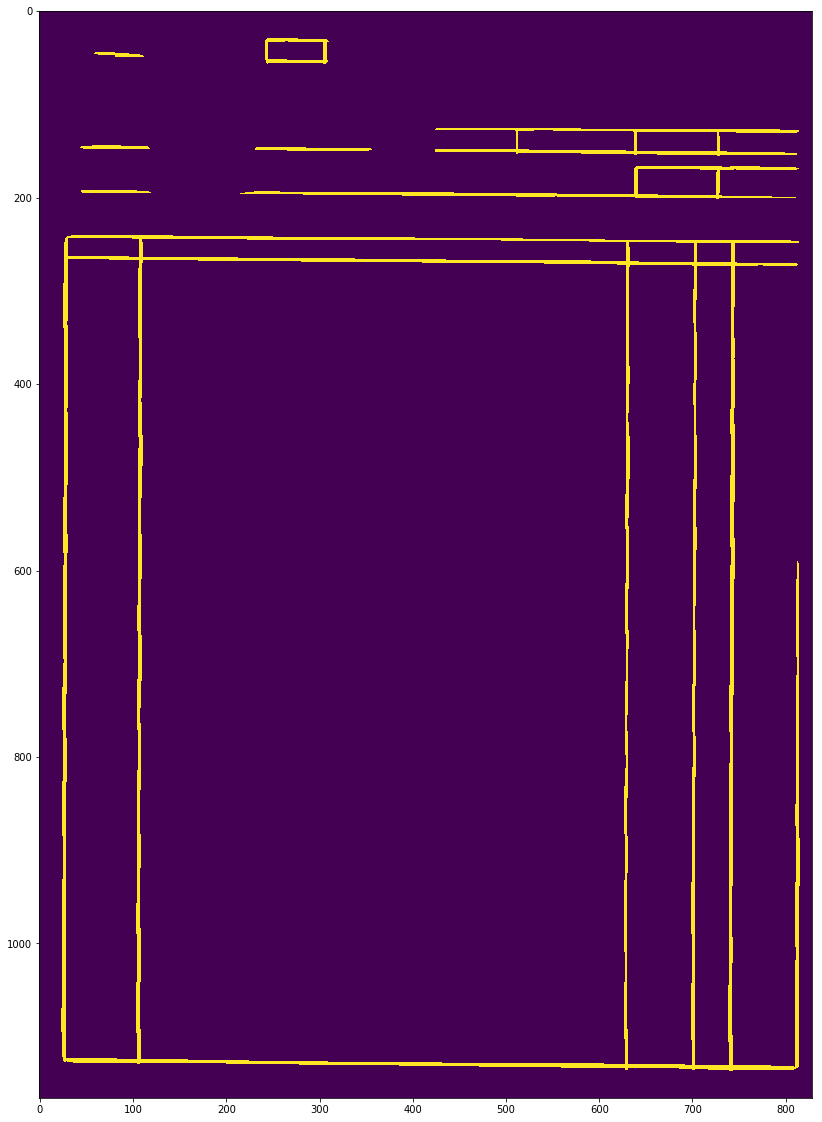

Run time show:  0.46
../data/test/SG1-46.png
Run time read_image:  0.04
Run time connect_line:  0.03
Run time connect_line:  0.02


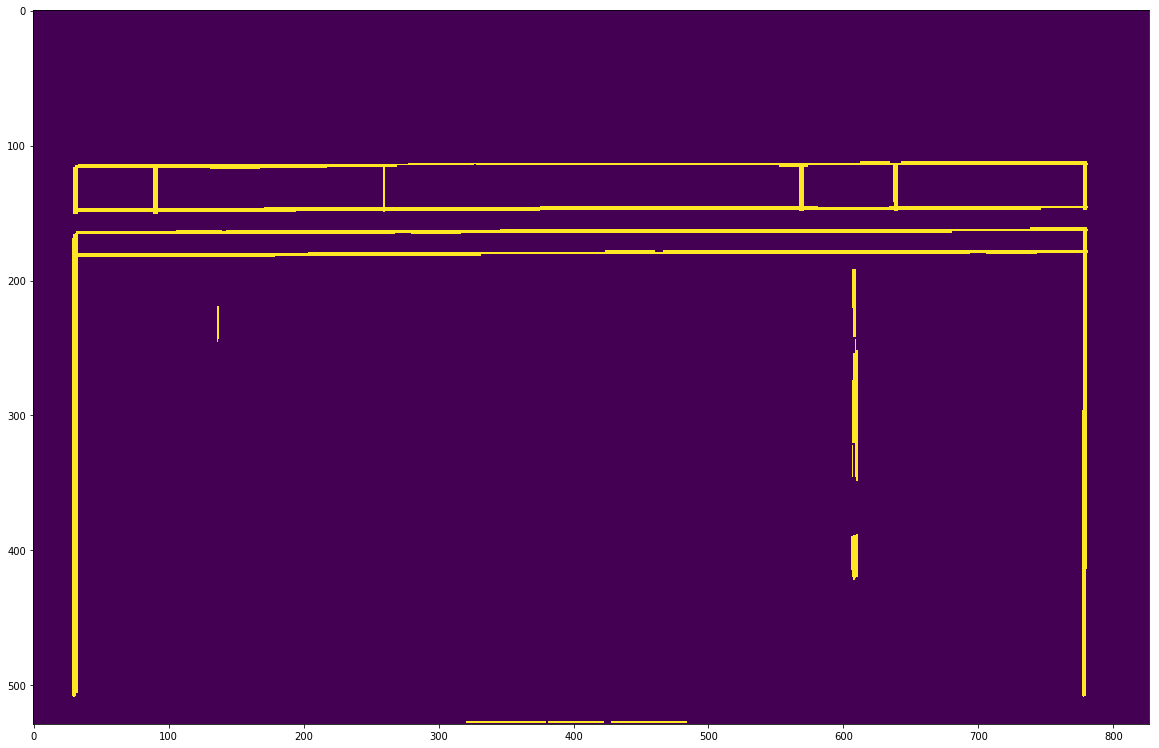

Run time show:  0.44
../data/test/SG1-18.png
Run time read_image:  0.05
Run time connect_line:  0.14
Run time connect_line:  0.05


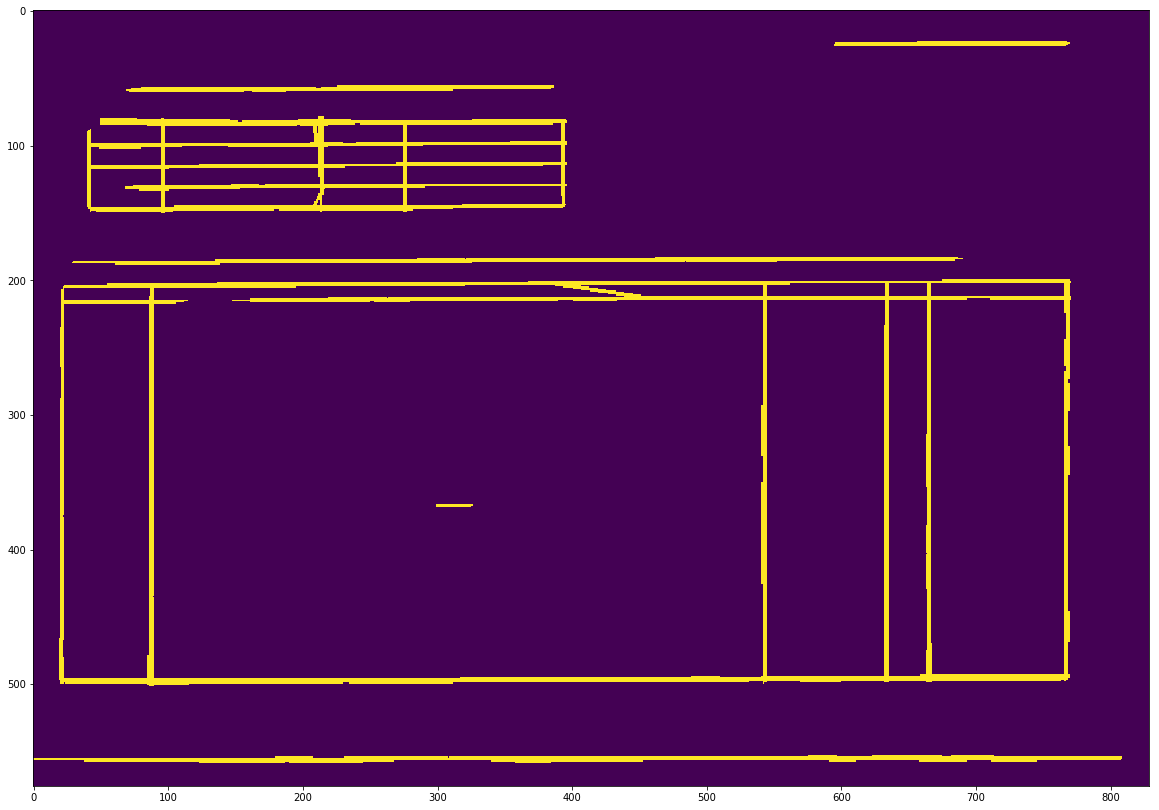

Run time show:  0.45
../data/test/SG1-48-3.png
Run time read_image:  0.10
Run time connect_line:  0.09
Run time connect_line:  0.12


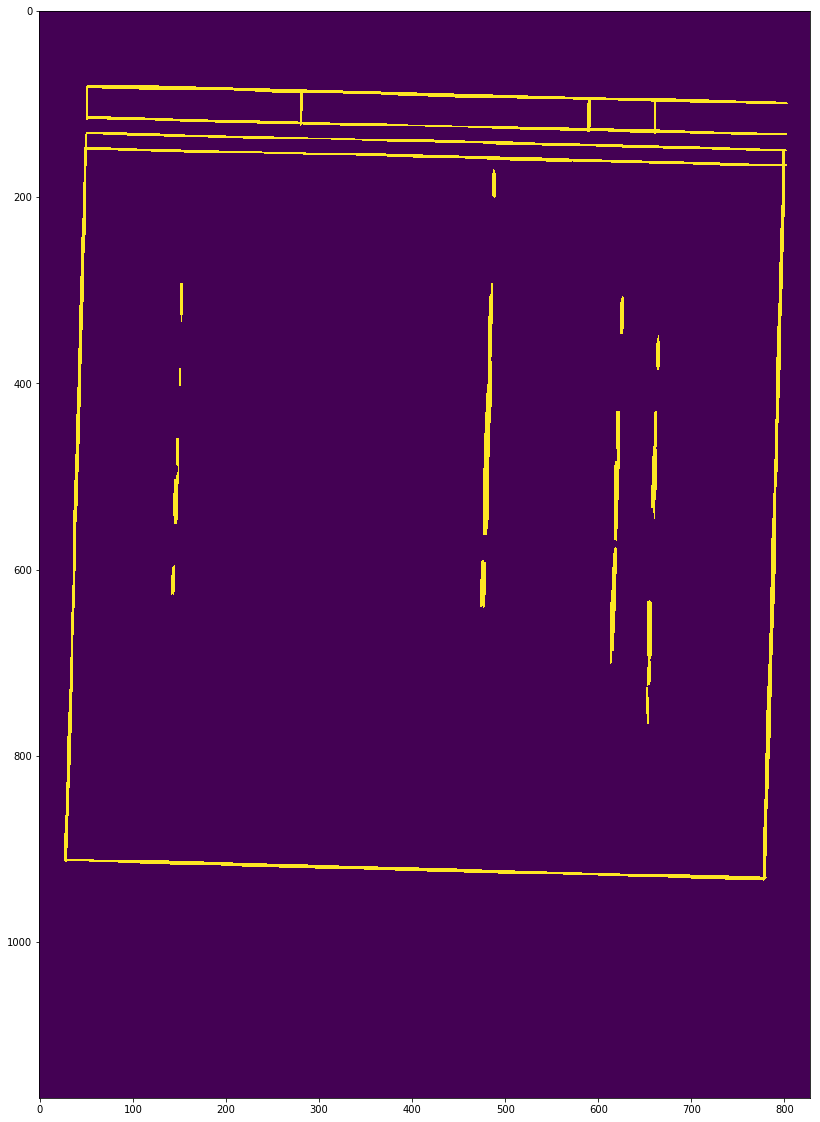

Run time show:  0.46
../data/test/SG1-24-2.png
Run time read_image:  0.09
Run time connect_line:  0.05
Run time connect_line:  0.07


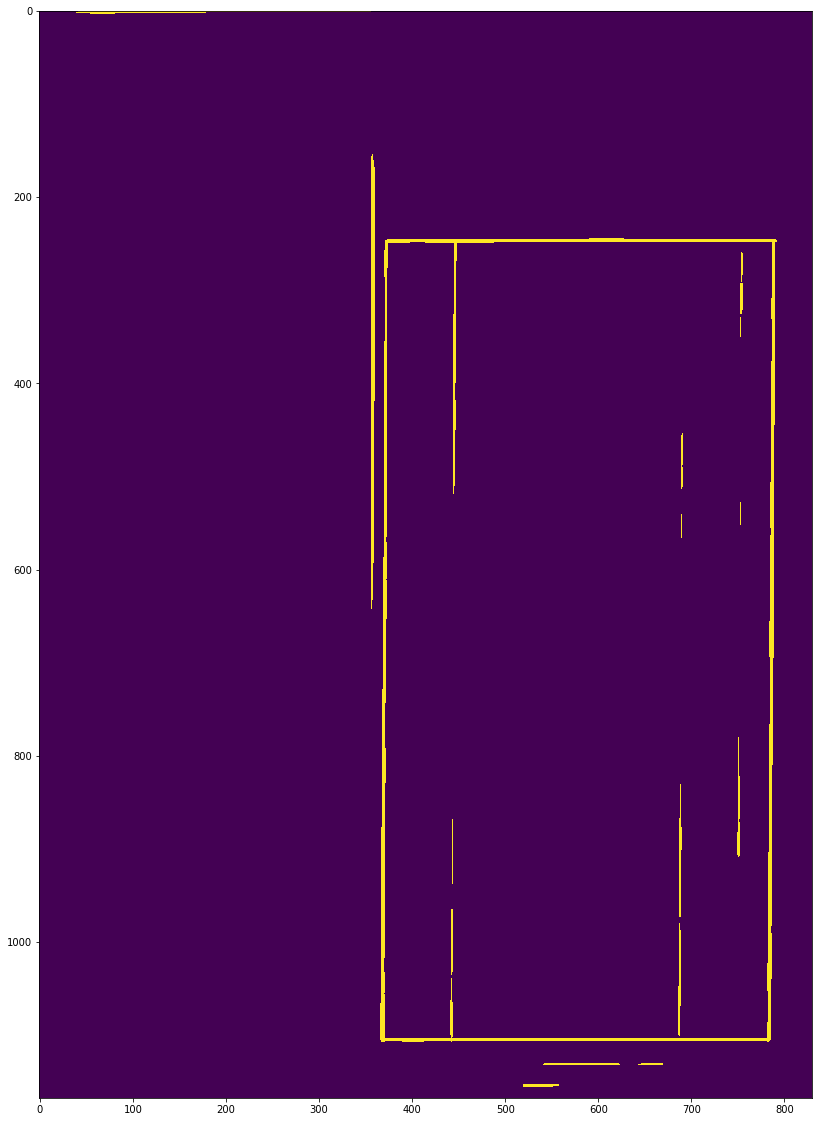

Run time show:  0.46
../data/test/SG1-1-1.png
Run time read_image:  0.10
Run time connect_line:  0.11
Run time connect_line:  0.10


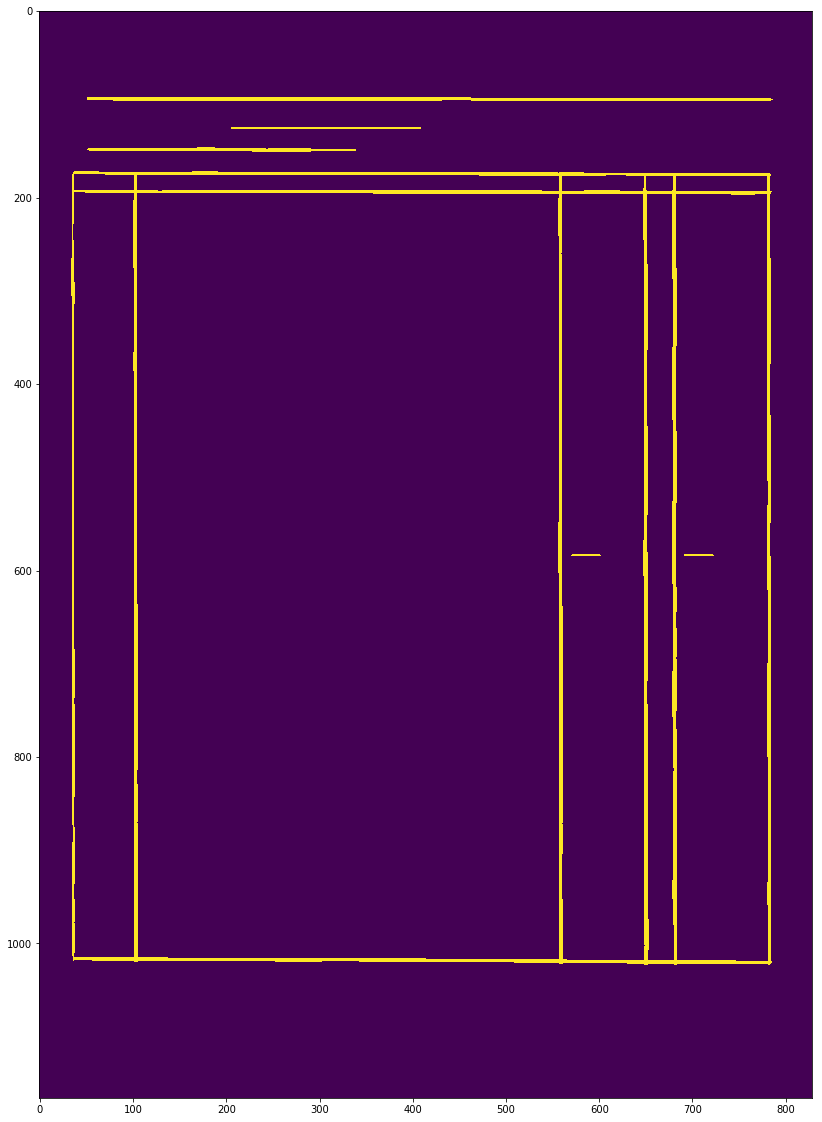

Run time show:  0.49
../data/test/SG1-2.png
Run time read_image:  0.10
Run time connect_line:  0.11
Run time connect_line:  0.09


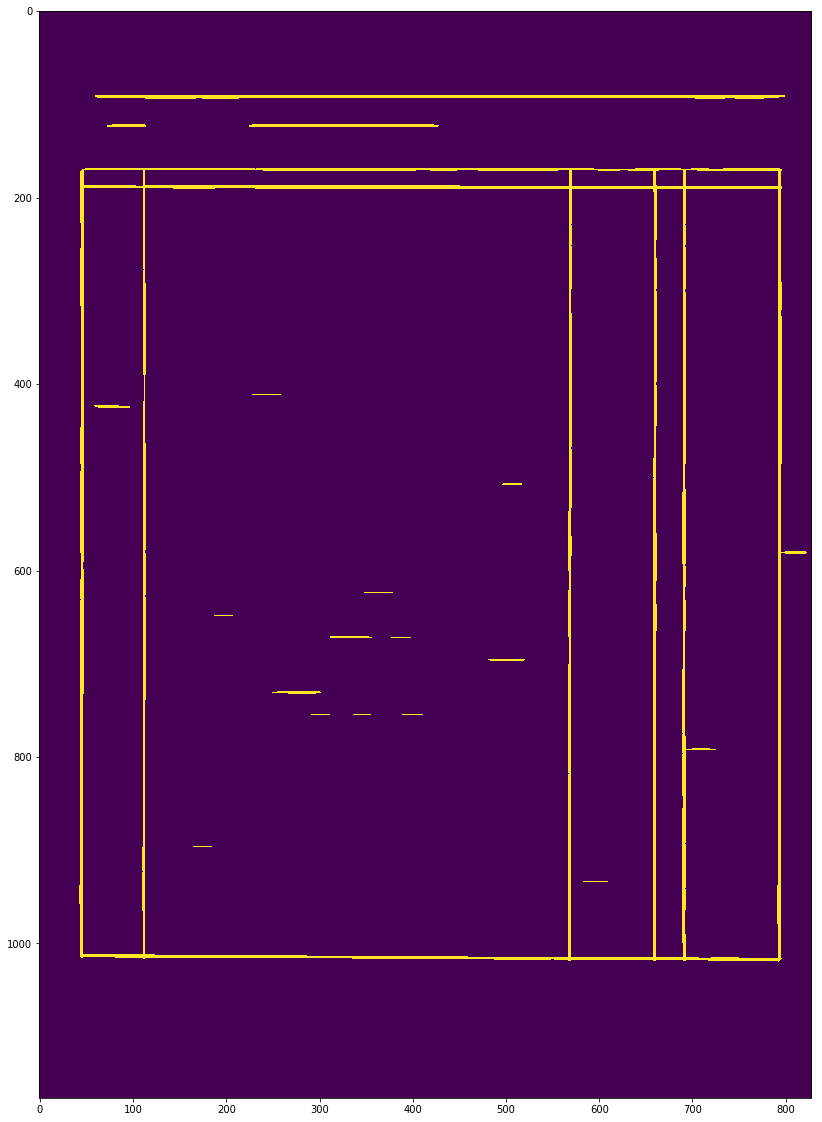

Run time show:  0.46
../data/test/SG1-27.png
Run time read_image:  0.08
Run time connect_line:  0.14
Run time connect_line:  0.10


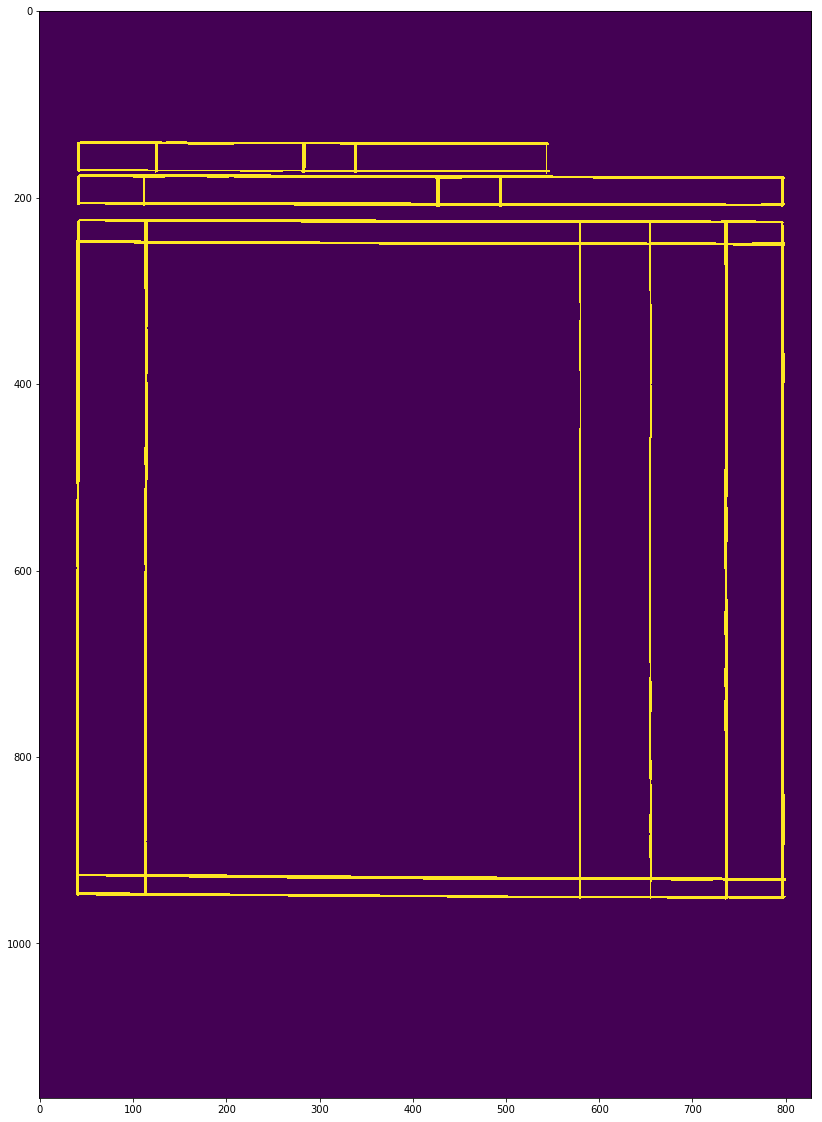

Run time show:  0.46
../data/test/SG1-31.png
Run time read_image:  0.07
Run time connect_line:  0.04
Run time connect_line:  0.07


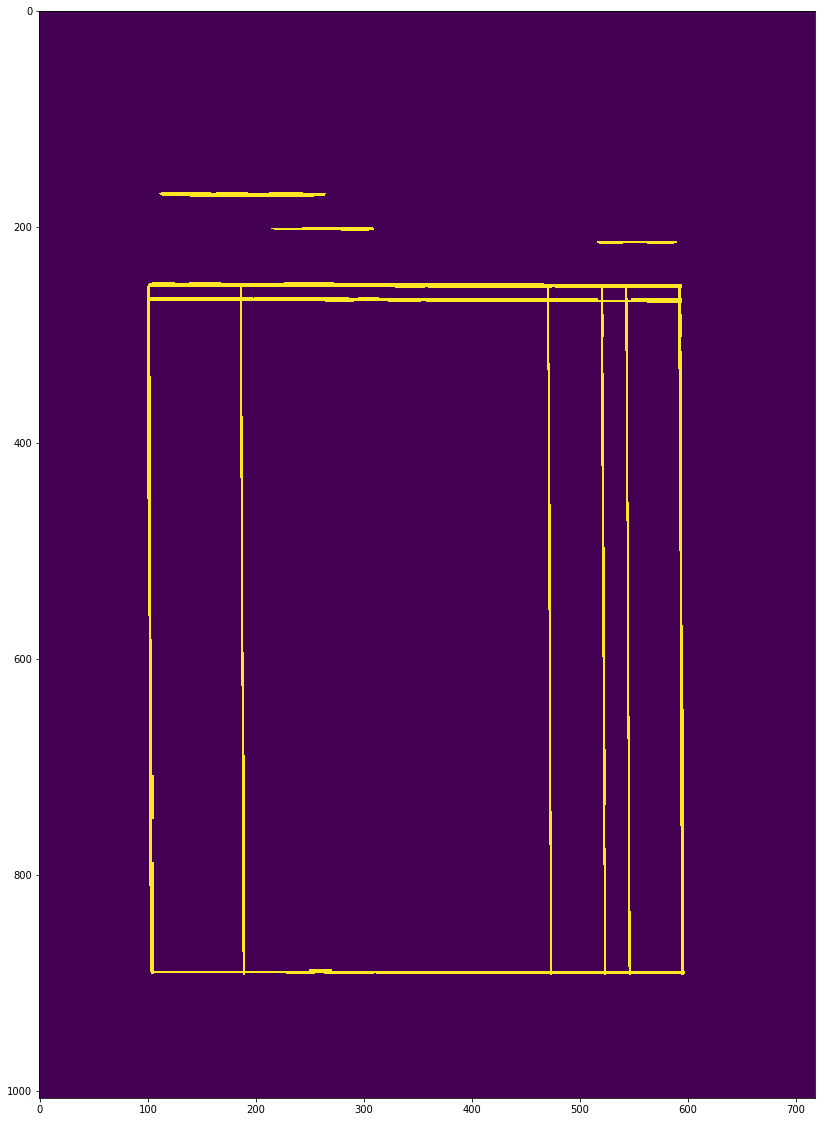

Run time show:  0.42
../data/test/SG1-20.png
Run time read_image:  0.04
Run time connect_line:  0.04
Run time connect_line:  0.05


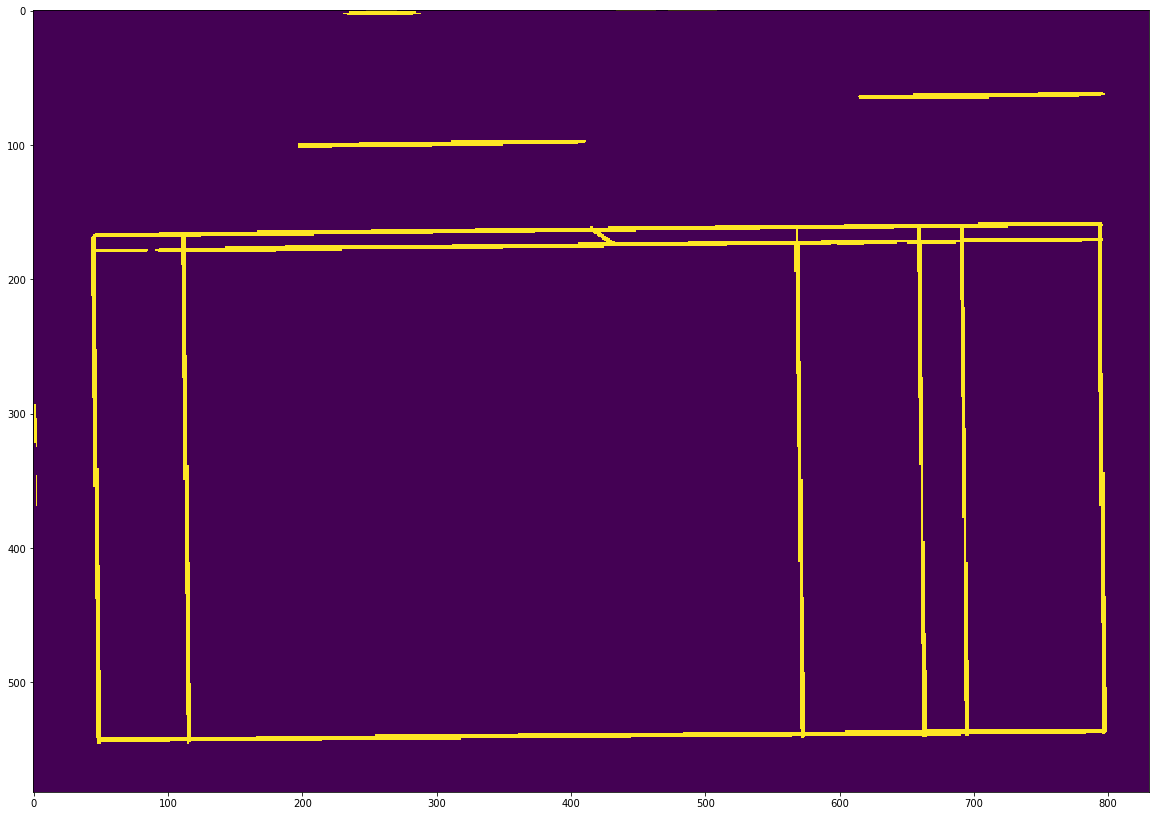

Run time show:  0.45
../data/test/SG1-34.png
Run time read_image:  0.04
Run time connect_line:  0.02
Run time connect_line:  0.09


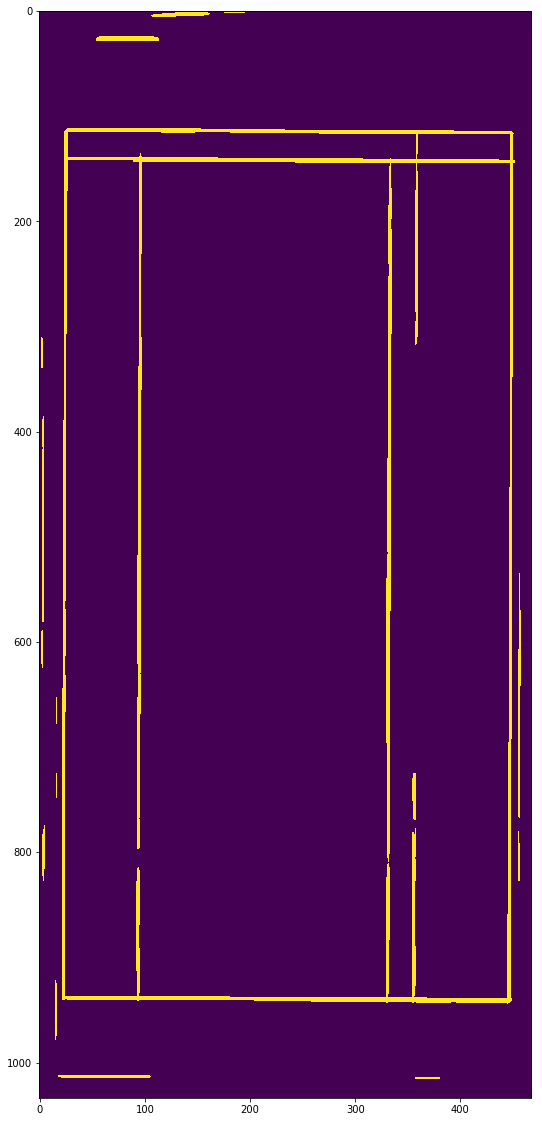

Run time show:  0.39
../data/test/SG1-5.png
Run time read_image:  0.09
Run time connect_line:  0.08
Run time connect_line:  0.10


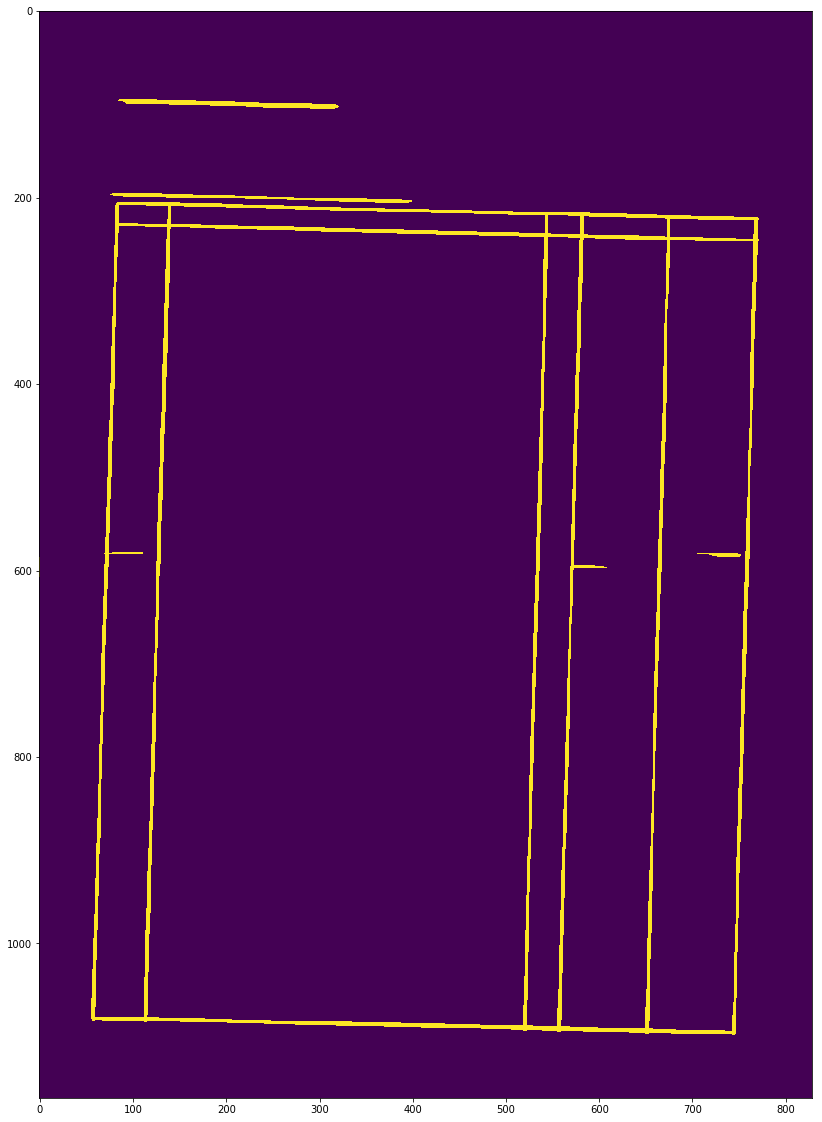

Run time show:  0.46
../data/test/SG1-41-1.png
Run time read_image:  0.07
Run time connect_line:  0.13
Run time connect_line:  0.08


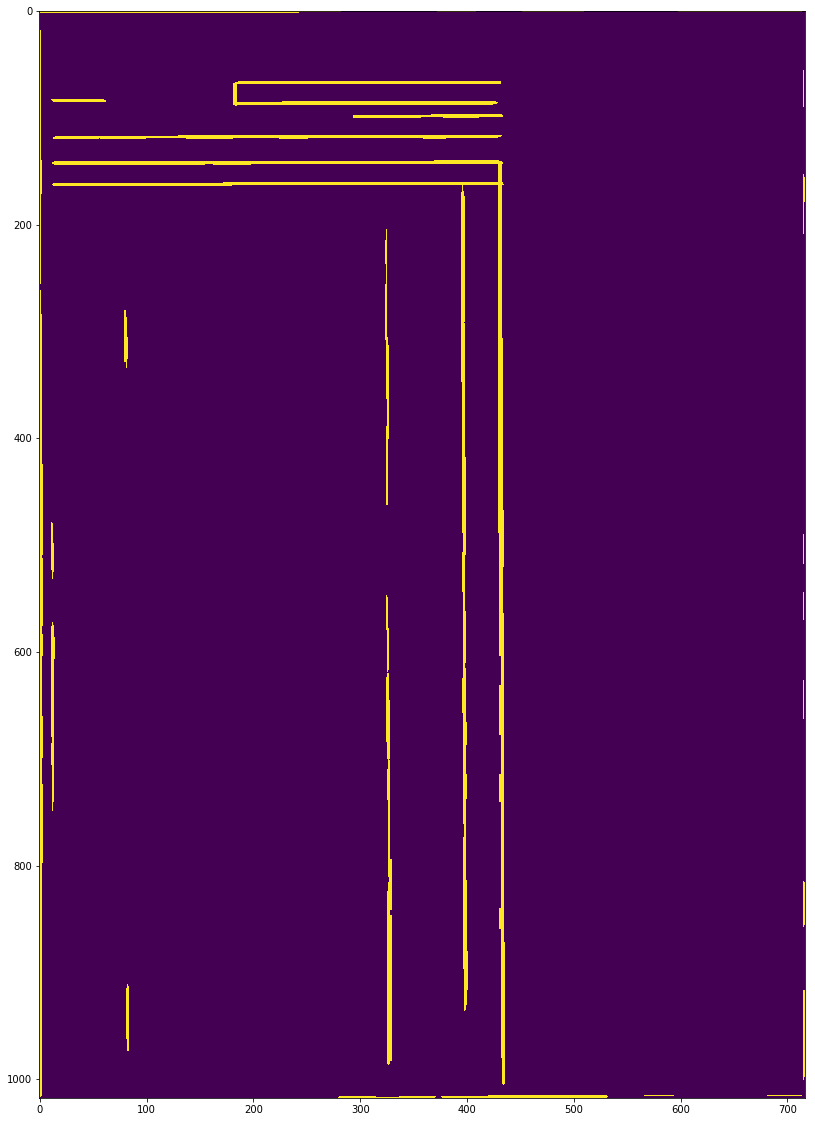

Run time show:  0.45
../data/test/SG1-40-1.png
Run time read_image:  0.11
Run time connect_line:  0.14
Run time connect_line:  0.10


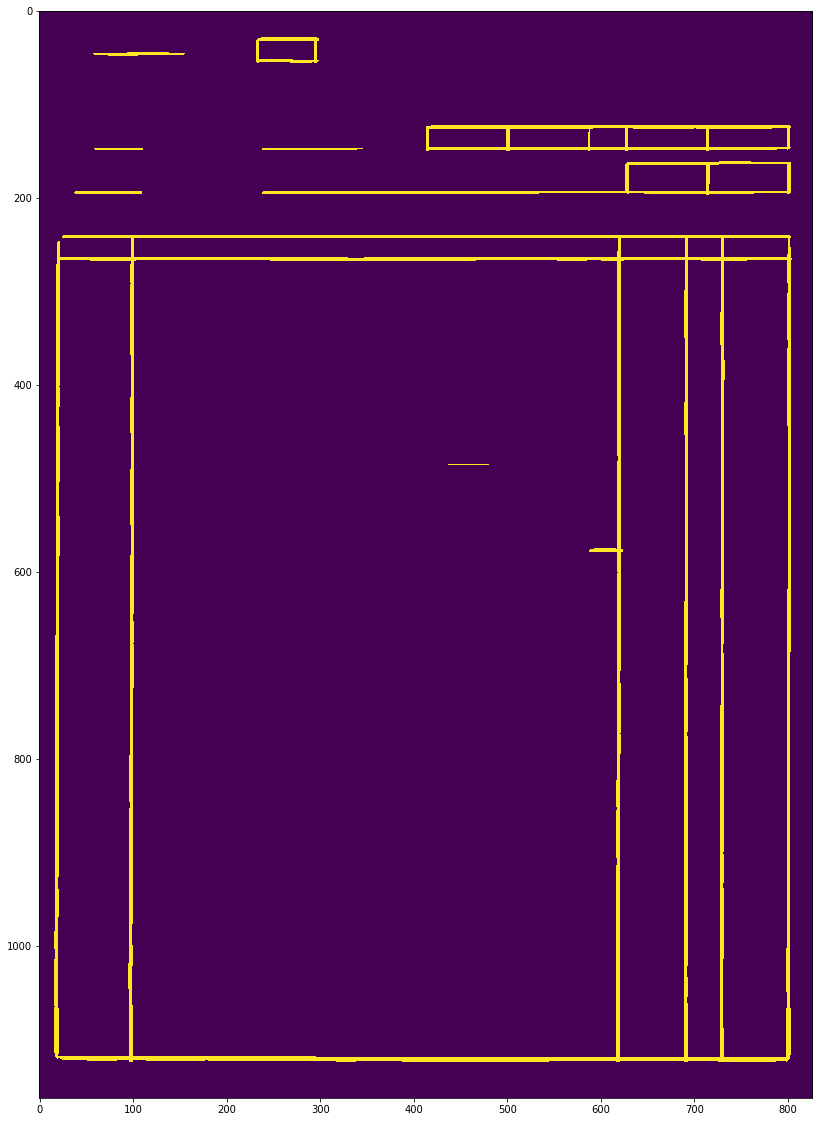

Run time show:  0.43


In [104]:
for path in paths:
#     path = paths[6]
    print(path)
    resize = .5
    img_ = read_image(path, channel=2, resize=resize)
    v_line = process(img_, 'get_v_line', thresh=150)
    h_line = process(img_, 'get_h_line', thresh=150)
    connect_h_line = connect_line(h_line,resize=resize, intersec_rate = .4)
    connect_v_line = connect_line(v_line,resize=resize, intersec_rate  = .4)
    show(cv2.add(connect_v_line, connect_h_line))
# show(connect_h_line)

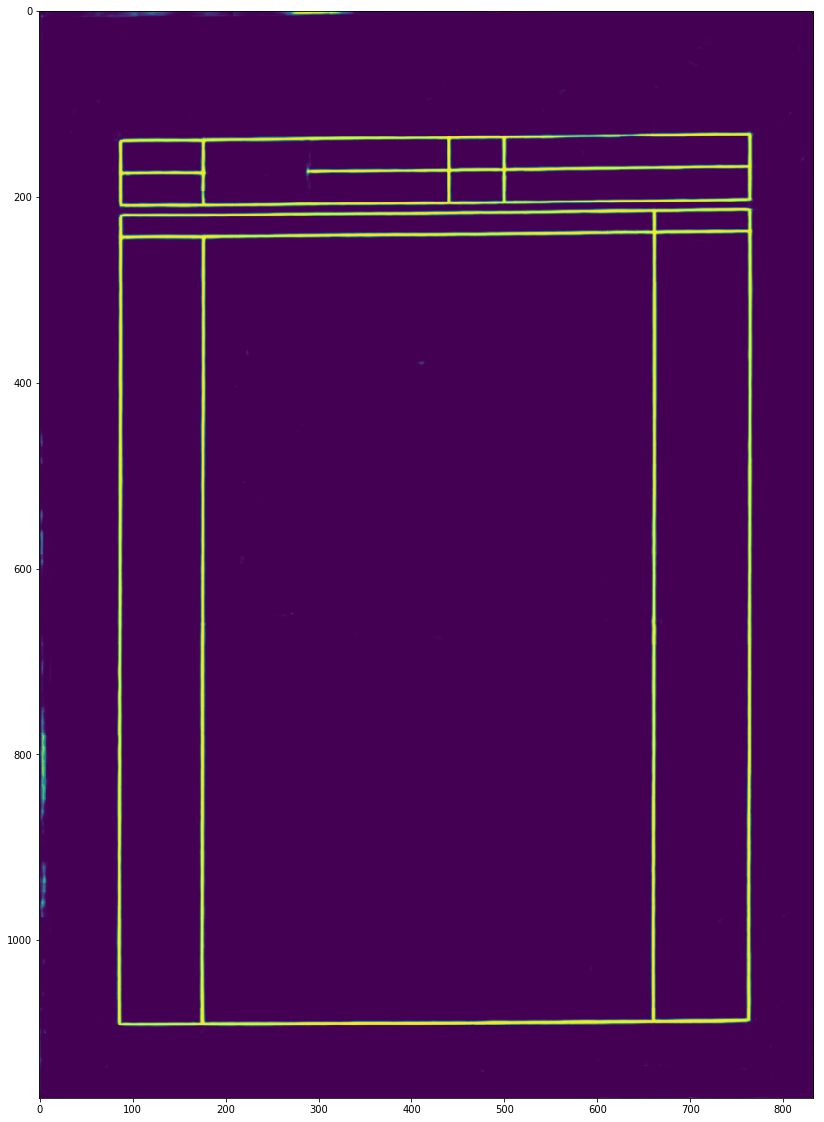

Run time show:  0.44


In [94]:
show(img_)